## Case Study

#### Task
The objective of the exercise is to build a predictive model using the provided dataset to predict if a customer is going to churn i.e. terminate their contract with the business.

Import Libraries:

In [1]:
import numpy as np 
import pandas as pd
import missingno as msno
import category_encoders as ce
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import StratifiedShuffleSplit
import warnings 
from scipy import stats
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from som import SOM
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import randint as sp_randint
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import statsmodels.api as sm
from pdpbox import pdp, get_dataset, info_plots
import random
import shap
import matplotlib.image as img 
from sklearn.tree import export_graphviz
import pydot
import os
from ann_visualizer.visualize import ann_viz
from IPython.display import display, Image

from imblearn.over_sampling import SMOTE
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
Using TensorFlow backend.


Load and review data:

In [2]:
df = pd.read_csv('data.csv', na_values=' ')
df.drop('customerID',axis=1,inplace=True)
print('This dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')
df.head()

This dataset has 7043 rows, and 20 columns


gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

Shuffle the dataset because some learning algorithms are sensitive to the order of the training instances. This will also guarantee that all cross-validation folds will be similar.

In [3]:
df = df.sample(frac=1,random_state=1)
df.reset_index(inplace=True,drop=True)

The Target of the model will be to predict the column 'Churn'. I can rename it with 'Target'.

In [4]:
df.rename(columns={'Churn':'Target'}, inplace=True)

Checking for nulls and data types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Target              7043 non-null object
dtypes: float64(2), int64(2), object(16)
memory usage: 1.1+ MB


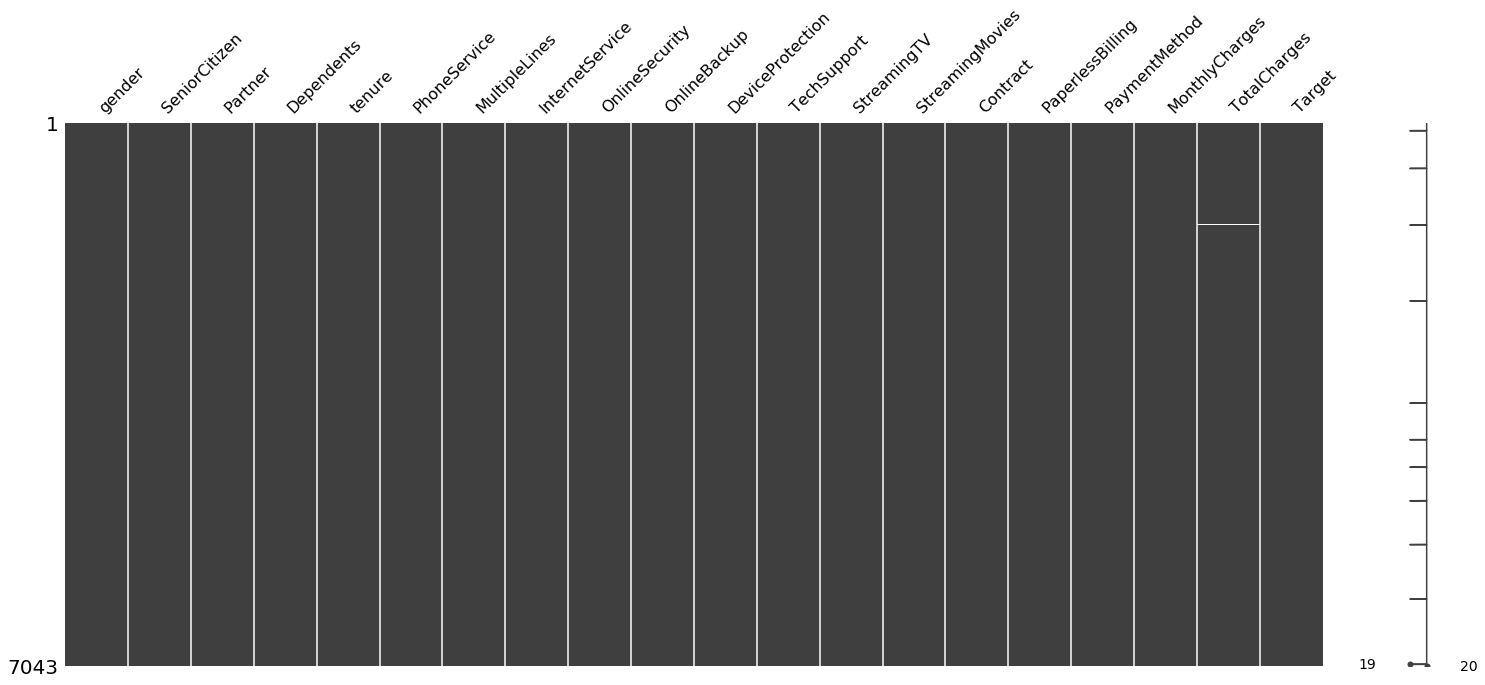

In [5]:
df.info()
msno.matrix(df)

There are few Null values in 'TotalCharges'. I can replace these value is the median of the feature:

In [6]:
df['TotalCharges'] = df['TotalCharges'].fillna((df['TotalCharges'].mean()))
df.isnull().isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Target              0
dtype: int64

Get list of numerical variables:

In [8]:
n = (df.dtypes != 'object')
numerical_cols = list(n[n].index)
print('Numerical variables: ', numerical_cols)
print('\nUnique values in SeniorCitizen: ',set(list(df['SeniorCitizen'])))

Numerical variables:  ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Unique values in SeniorCitizen:  {0, 1}


'SeniorCitizen' is a categorical features even if the values are numeric. '1' could be 'YES' and '0' usually means 'NO'. Because of these considerations, I will remove this column from the list.

In [9]:
numerical_cols.remove('SeniorCitizen')

Get list of categorical variables:

In [10]:
c = (df.dtypes == 'object')
object_cols = list(c[c].index)
object_cols = ['SeniorCitizen'] + object_cols
print('Categorical variables:')
print(object_cols)

Categorical variables:
['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Target']


In the case of classification problems where input variables are also categorical, we can use statistical tests to determine whether the output variable is dependent or independent of the input variables. If independent, then the input variable is a candidate for a feature that may be irrelevant to the problem and removed from the dataset.

The Pearson’s chi-squared statistical hypothesis is an example of a test for independence between categorical variables.

Feature = SeniorCitizen
dof = 1
probability = 0.950, critical = 3.841, stat = 159.426
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



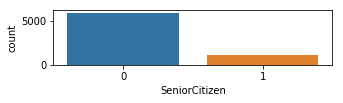




Feature = gender
dof = 1
probability = 0.950, critical = 3.841, stat = 0.484
Independent (fail to reject H0)
significance = 0.050, p = 0.487
Independent (fail to reject H0)



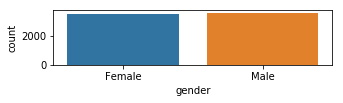




Feature = Partner
dof = 1
probability = 0.950, critical = 3.841, stat = 158.733
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



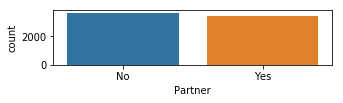




Feature = Dependents
dof = 1
probability = 0.950, critical = 3.841, stat = 189.129
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



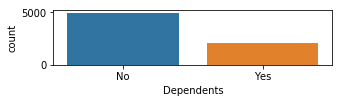




Feature = PhoneService
dof = 1
probability = 0.950, critical = 3.841, stat = 0.915
Independent (fail to reject H0)
significance = 0.050, p = 0.339
Independent (fail to reject H0)



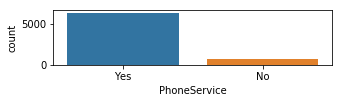




Feature = MultipleLines
dof = 2
probability = 0.950, critical = 5.991, stat = 11.330
Dependent (reject H0)
significance = 0.050, p = 0.003
Dependent (reject H0)



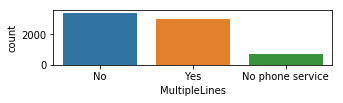




Feature = InternetService
dof = 2
probability = 0.950, critical = 5.991, stat = 732.310
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



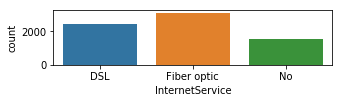




Feature = OnlineSecurity
dof = 2
probability = 0.950, critical = 5.991, stat = 849.999
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



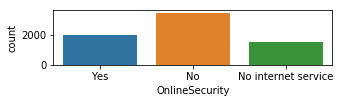




Feature = OnlineBackup
dof = 2
probability = 0.950, critical = 5.991, stat = 601.813
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



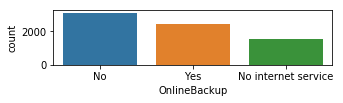




Feature = DeviceProtection
dof = 2
probability = 0.950, critical = 5.991, stat = 558.419
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



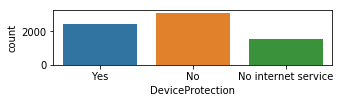




Feature = TechSupport
dof = 2
probability = 0.950, critical = 5.991, stat = 828.197
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



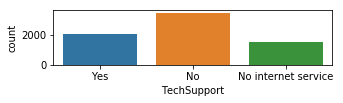




Feature = StreamingTV
dof = 2
probability = 0.950, critical = 5.991, stat = 374.204
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



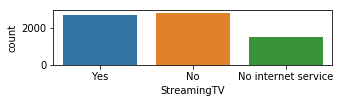




Feature = StreamingMovies
dof = 2
probability = 0.950, critical = 5.991, stat = 375.661
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



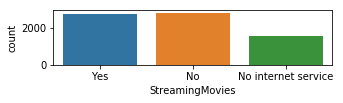




Feature = Contract
dof = 2
probability = 0.950, critical = 5.991, stat = 1184.597
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



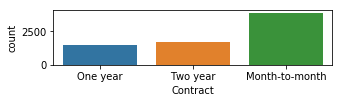




Feature = PaperlessBilling
dof = 1
probability = 0.950, critical = 3.841, stat = 258.278
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



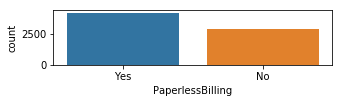




Feature = PaymentMethod
dof = 3
probability = 0.950, critical = 7.815, stat = 648.142
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)



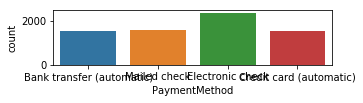

In [11]:
cols = object_cols[:-1]
for c in cols:   
    # contingency table
    print('Feature =',c)
    table = np.array(pd.crosstab(df['Target'], df[c], margins = False))
    stat, p, dof, expected = chi2_contingency(table)
    print('dof = %d' % dof)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability = %.3f, critical = %.3f, stat = %.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance = %.3f, p = %.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)\n')
    else:
        print('Independent (fail to reject H0)\n')
    plt.figure(figsize=(5,1))
    sns.countplot(df[c])
    plt.show()  
    print('\n\n')

There are few irrelevant categorical features.

I can visualize the unique values for every categorical features:

In [12]:
for c in object_cols:
    print(c,'  ',set(df[c]))

SeniorCitizen    {0, 1}
gender    {'Male', 'Female'}
Partner    {'Yes', 'No'}
Dependents    {'Yes', 'No'}
PhoneService    {'Yes', 'No'}
MultipleLines    {'Yes', 'No phone service', 'No'}
InternetService    {'No', 'DSL', 'Fiber optic'}
OnlineSecurity    {'Yes', 'No internet service', 'No'}
OnlineBackup    {'Yes', 'No internet service', 'No'}
DeviceProtection    {'Yes', 'No internet service', 'No'}
TechSupport    {'Yes', 'No internet service', 'No'}
StreamingTV    {'Yes', 'No internet service', 'No'}
StreamingMovies    {'Yes', 'No internet service', 'No'}
Contract    {'One year', 'Month-to-month', 'Two year'}
PaperlessBilling    {'Yes', 'No'}
PaymentMethod    {'Electronic check', 'Bank transfer (automatic)', 'Credit card (automatic)', 'Mailed check'}
Target    {'Yes', 'No'}


## Encoding
Binary variables: 'gender','Partner','Dependents','PhoneService','PaperlessBilling','Target'

In [13]:
col_binary = ['gender','Partner','Dependents','PhoneService','PaperlessBilling','Target']
for i in col_binary:
    df[i] = np.where((df[i].str.contains('Yes') | df[i].str.contains('Male')), 1, 0)
df.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        0           0      41             1   
1       0              1        0           0      66             1   
2       0              0        0           0      12             1   
3       0              0        0           0       5             1   
4       0              0        1           1      10             1   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL            Yes           No              Yes   
1           Yes     Fiber optic            Yes           No               No   
2            No             DSL             No           No               No   
3           Yes             DSL             No           No               No   
4            No             DSL             No          Yes              Yes   

  TechSupport StreamingTV StreamingMovies        Contract  PaperlessBilling  \
0         Yes         Yes             Yes        One year                 1   
1          No         Yes             Yes        Two year                 1   
2          No          No              No  Month-to-month                 1   
3          No          No              No  Month-to-month                 1   
4          No          No             Yes        One year                 1   

               PaymentMethod  MonthlyCharges  TotalCharges  Target  
0  Bank transfer (automatic)           79.85       3320.75       0  
1  Bank transfer (automatic)          102.40       6471.85       0  
2  Bank transfer (automatic)           45.00        524.35       0  
3               Mailed check           50.60        249.95       1  
4               Mailed check           65.90        660.05       0

Odinal encoding: 'Contract'

In [14]:
cleanup_nums = {'Contract': {'Month-to-month': 1, 'One year': 2, 'Two year': 3}}
df.replace(cleanup_nums, inplace=True)
df.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        0           0      41             1   
1       0              1        0           0      66             1   
2       0              0        0           0      12             1   
3       0              0        0           0       5             1   
4       0              0        1           1      10             1   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL            Yes           No              Yes   
1           Yes     Fiber optic            Yes           No               No   
2            No             DSL             No           No               No   
3           Yes             DSL             No           No               No   
4            No             DSL             No          Yes              Yes   

  TechSupport StreamingTV StreamingMovies  Contract  PaperlessBilling  \
0         Yes         Yes             Yes         2                 1   
1          No         Yes             Yes         3                 1   
2          No          No              No         1                 1   
3          No          No              No         1                 1   
4          No          No             Yes         2                 1   

               PaymentMethod  MonthlyCharges  TotalCharges  Target  
0  Bank transfer (automatic)           79.85       3320.75       0  
1  Bank transfer (automatic)          102.40       6471.85       0  
2  Bank transfer (automatic)           45.00        524.35       0  
3               Mailed check           50.60        249.95       1  
4               Mailed check           65.90        660.05       0

Target encoding:

In [15]:
col_target = ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaymentMethod']

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)
    train = dataframe[:-valid_size * 2]
    valid = dataframe[-valid_size * 2:-valid_size] # valid size == test size, last two sections of the data
    test = dataframe[-valid_size:]
    return train, valid, test    

target_enc = ce.TargetEncoder(cols=col_target) # Create the encoder itself
train, valid, _ = get_data_splits(df)
target_enc.fit(train[col_target], train['Target']) # Fit the encoder using the categorical features and target
df = df.join(target_enc.transform(df[col_target]).add_suffix('_target'))
df = df.drop(col_target,axis=1)

# Placing Target column on the right
cols = list(df.columns)
cols.remove('Target')
cols.append('Target')
df = df[cols]
    
df.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  Contract  \
0       0              0        0           0      41             1         2   
1       0              1        0           0      66             1         3   
2       0              0        0           0      12             1         1   
3       0              0        0           0       5             1         1   
4       0              0        1           1      10             1         2   

   PaperlessBilling  MonthlyCharges  TotalCharges  MultipleLines_target  \
0                 1           79.85       3320.75              0.251015   
1                 1          102.40       6471.85              0.282581   
2                 1           45.00        524.35              0.251015   
3                 1           50.60        249.95              0.282581   
4                 1           65.90        660.05              0.251015   

   InternetService_target  OnlineSecurity_target  OnlineBackup_target  \
0                0.184995               0.139178             0.398793   
1                0.417203               0.139178             0.398793   
2                0.184995               0.417767             0.398793   
3                0.184995               0.417767             0.398793   
4                0.184995               0.417767             0.208825   

   DeviceProtection_target  TechSupport_target  StreamingTV_target  \
0                 0.222854            0.147005            0.298432   
1                 0.386800            0.415318            0.298432   
2                 0.386800            0.415318            0.331421   
3                 0.386800            0.415318            0.331421   
4                 0.222854            0.415318            0.331421   

   StreamingMovies_target  PaymentMethod_target  Target  
0                0.297745              0.169218       0  
1                0.297745              0.169218       0  
2                0.332154              0.169218       0  
3                0.332154              0.190585       1  
4                0.297745              0.190585       0

Visualize the correlation of the data:

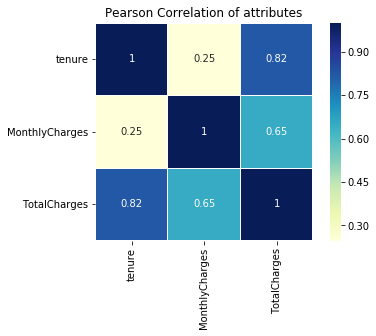

In [16]:
colormap = plt.cm.viridis
plt.title('Pearson Correlation of attributes')
heatmap = sns.heatmap(df[numerical_cols].corr(),
                      linewidths=0.1,
                      vmax=1.0, 
                      square=True, 
                      cmap='YlGnBu', 
                      linecolor='white',
                      annot=True)

There a features highly correlated. I am not going to drop anything at the moment. I can also check the pairplot: you can zoom the chart by double-clicking on it.

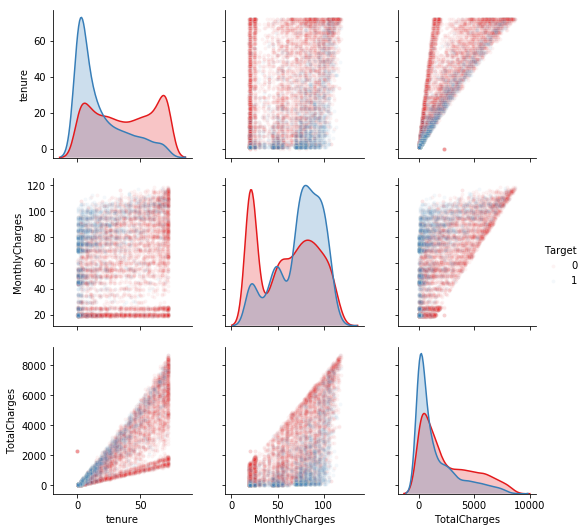

In [17]:
pairplot = sns.pairplot(df,
                        palette='Set1',
                        diag_kind='kde',
                        hue='Target', 
                        plot_kws={"s": 15,'alpha': 0.05},
                        vars=list(df[numerical_cols].columns))

#### Observation:
- There are few leverage points
- It looks like there are at least 2 clusters in the data
- 'tenure' should be an important feature: the 2 distributions in the main diagolnal are clearly separable

## Scaling the data: 
#### normalization
Since many machine learning techniques are sensitive to different scales of the data, I am going to normalize all the indipendend variables in the dataset.

In [18]:
X = df.drop(['Target'],axis=1)
y = df['Target']
columns = X.columns.to_list()
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = columns
extra_cols = df.iloc[:,-1:]
df = pd.concat([pd.DataFrame(X),pd.DataFrame(y)],axis=1)
df.head()

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0     0.0            0.0      0.0         0.0  0.569444           1.0   
1     0.0            1.0      0.0         0.0  0.916667           1.0   
2     0.0            0.0      0.0         0.0  0.166667           1.0   
3     0.0            0.0      0.0         0.0  0.069444           1.0   
4     0.0            0.0      1.0         1.0  0.138889           1.0   

   Contract  PaperlessBilling  MonthlyCharges  TotalCharges  \
0       0.5               1.0        0.612935      0.381024   
1       1.0               1.0        0.837313      0.744640   
2       0.0               1.0        0.266169      0.058337   
3       0.0               1.0        0.321891      0.026673   
4       0.5               1.0        0.474129      0.073996   

   MultipleLines_target  InternetService_target  OnlineSecurity_target  \
0              0.017575                0.319901               0.185406   
1              1.000000                1.000000               0.185406   
2              0.017575                0.319901               1.000000   
3              1.000000                0.319901               1.000000   
4              0.017575                0.319901               1.000000   

   OnlineBackup_target  DeviceProtection_target  TechSupport_target  \
0             1.000000                 0.472894            0.209794   
1             1.000000                 1.000000            1.000000   
2             1.000000                 1.000000            1.000000   
3             1.000000                 1.000000            1.000000   
4             0.411906                 0.472894            1.000000   

   StreamingTV_target  StreamingMovies_target  PaymentMethod_target  Target  
0             0.87096                0.865792              0.052135       0  
1             0.87096                0.865792              0.052135       0  
2             1.00000                1.000000              0.052135       0  
3             1.00000                1.000000              0.124600       1  
4             1.00000                0.865792              0.124600       0

Reduce the memory size without loosing any information:

In [19]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(props[col].median(),inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

df, NAlist = reduce_mem_usage(df)

Memory usage of properties dataframe is : 1.0479316711425781  MB
******************************
Column:  gender
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  SeniorCitizen
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  Partner
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  Dependents
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  tenure
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  PhoneService
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  Contract
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  PaperlessBilling
dtype b

#### Leverage Points:

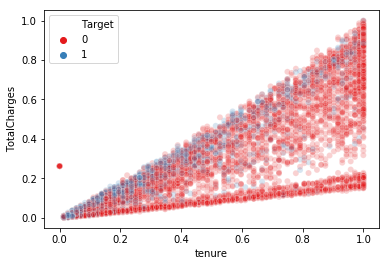

In [20]:
sns.scatterplot(x='tenure', y='TotalCharges', hue='Target', data=df, palette='Set1', alpha= 0.2)

I can clearly see in the 'tenure'-'TotalCharges' scatterplot that there is at least 1 lavarage point at 'tenure'~0 and 'TotalCharges'~0.25. Let's train a few anomaly detectors to see how they perform:

OUTLIERS :  0 INLIERS :  7043 Angle-based Outlier Detector (ABOD)


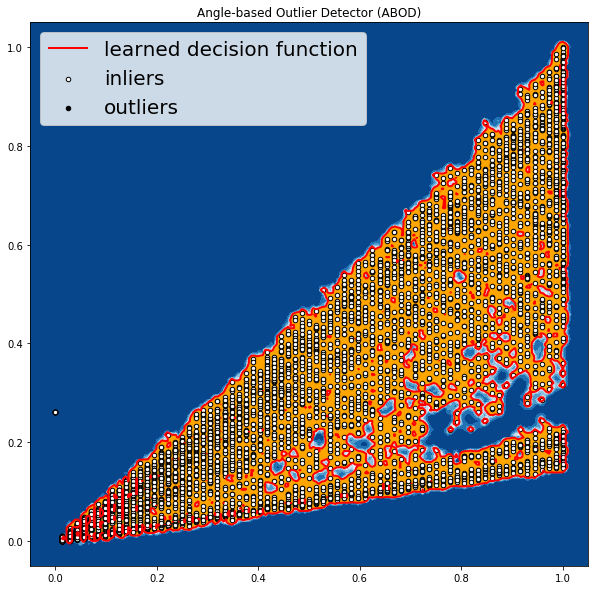

OUTLIERS :  353 INLIERS :  6690 Cluster-based Local Outlier Factor (CBLOF)


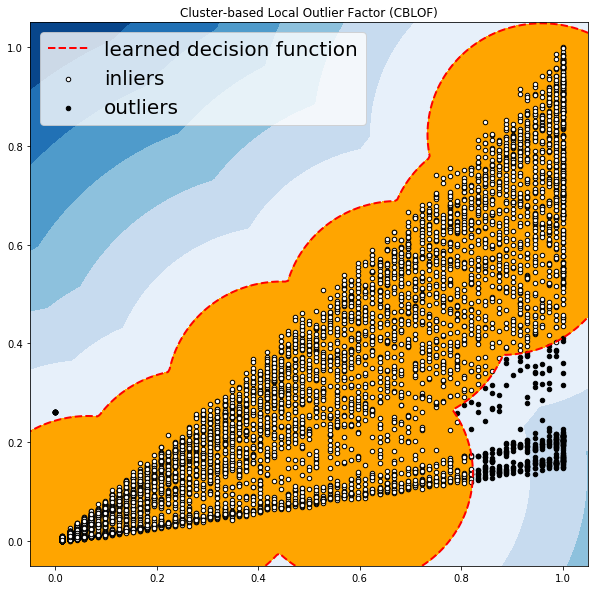

OUTLIERS :  353 INLIERS :  6690 Isolation Forest


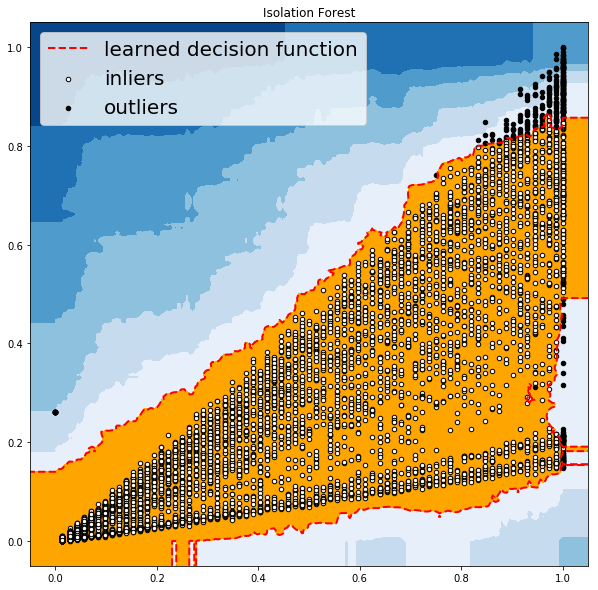

OUTLIERS :  230 INLIERS :  6813 K Nearest Neighbors (KNN)


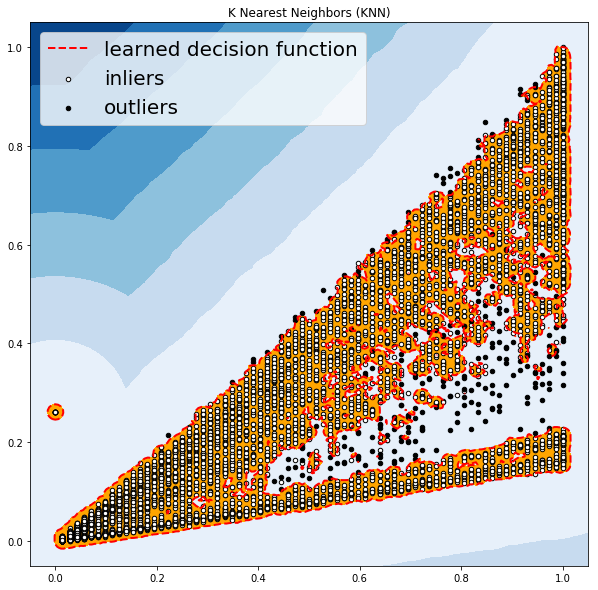

In [21]:
#https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

warnings.filterwarnings('ignore')

feature1 = 'tenure'
feature2 = 'TotalCharges'
X1 = df[feature1].values.reshape(-1,1)
X2 = df[feature2].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)
random_state = np.random.RandomState(42)
outliers_fraction = 0.05

# Define seven outlier detection tools to be compared
classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
               'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
               'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
               'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction)}

xx , yy = np.meshgrid(np.linspace(-0.05, 1.05 , 200), np.linspace(-0.05, 1.05, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx[feature1][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx[feature2][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx[feature1][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx[feature2][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(clf_name)
    plt.show()

df = df.drop(['outlier'],axis=1)

Most of them are not able to classify that point as outliers. The reason is there are multiple points overlaying on the top of each other. 

I can try to undestand the number of records by selecting them manually:

In [22]:
lavarage_point = df[['tenure','TotalCharges']][(df['tenure']<0.05) & (df['TotalCharges']>0.2)]
print('There are %.0f lavarage points' %len(lavarage_point))
lavarage_point

There are 11 lavarage points


tenure  TotalCharges
103      0.0      0.261309
592      0.0      0.261309
1327     0.0      0.261309
2308     0.0      0.261309
3633     0.0      0.261309
4106     0.0      0.261309
4463     0.0      0.261309
4897     0.0      0.261309
5465     0.0      0.261309
6170     0.0      0.261309
7016     0.0      0.261309

## Unsupervised Learning: 

All these methods detects outliers looking at only 2 features at the time. There might be outliers in a multidimensional space.

I could also try SOMs (Self Organised Maps) in order to detect them. It a type of artificial neural network (ANN) that is trained using unsupervised learning to produce a low-dimensional (typically two-dimensional), discretized representation of the input space, called a map, and is therefore a method to do dimensionality reduction. Self-organizing maps differ from other artificial neural networks as they apply competitive learning as opposed to error-correction learning (such as backpropagation with gradient descent), and in the sense that they use a neighborhood function to preserve the topological properties of the input space.

In [22]:
som = SOM(20, 20)
data = np.array(df.drop(['Target'],axis=1))
target = np.array(df['Target'])
som.fit(data, 150, save_e=True, interval=10)

Epoch 0;    Neuron [8, 6];    	Sigma: 10.0000;    alpha: 0.6000
Epoch 1;    Neuron [17, 15];    	Sigma: 10.0000;    alpha: 0.6000
Epoch 2;    Neuron [13, 18];    	Sigma: 10.0000;    alpha: 0.6000
Epoch 3;    Neuron [11, 18];    	Sigma: 10.0000;    alpha: 0.6000
Epoch 4;    Neuron [5, 9];    	Sigma: 9.9999;    alpha: 0.6000
Epoch 5;    Neuron [12, 15];    	Sigma: 9.9998;    alpha: 0.6000
Epoch 6;    Neuron [1, 18];    	Sigma: 9.9996;    alpha: 0.6000
Epoch 7;    Neuron [6, 5];    	Sigma: 9.9992;    alpha: 0.6000
Epoch 8;    Neuron [0, 14];    	Sigma: 9.9987;    alpha: 0.5999
Epoch 9;    Neuron [12, 8];    	Sigma: 9.9979;    alpha: 0.5999
Epoch 10;    Neuron [18, 1];    	Sigma: 9.9968;    alpha: 0.5998
Epoch 11;    Neuron [15, 7];    	Sigma: 9.9952;    alpha: 0.5997
Epoch 12;    Neuron [10, 17];    	Sigma: 9.9933;    alpha: 0.5996
Epoch 13;    Neuron [16, 11];    	Sigma: 9.9907;    alpha: 0.5994
Epoch 14;    Neuron [2, 14];    	Sigma: 9.9875;    alpha: 0.5993
Epoch 15;    Neuron [6, 4]; 

I could plot the training error history:

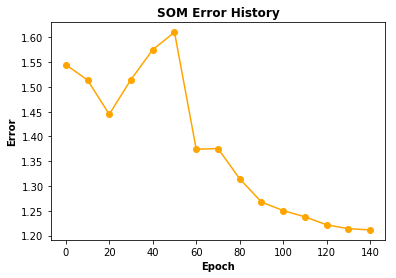

In [23]:
som.plot_error_history()

Now I visualize the learned representation with the group labels:

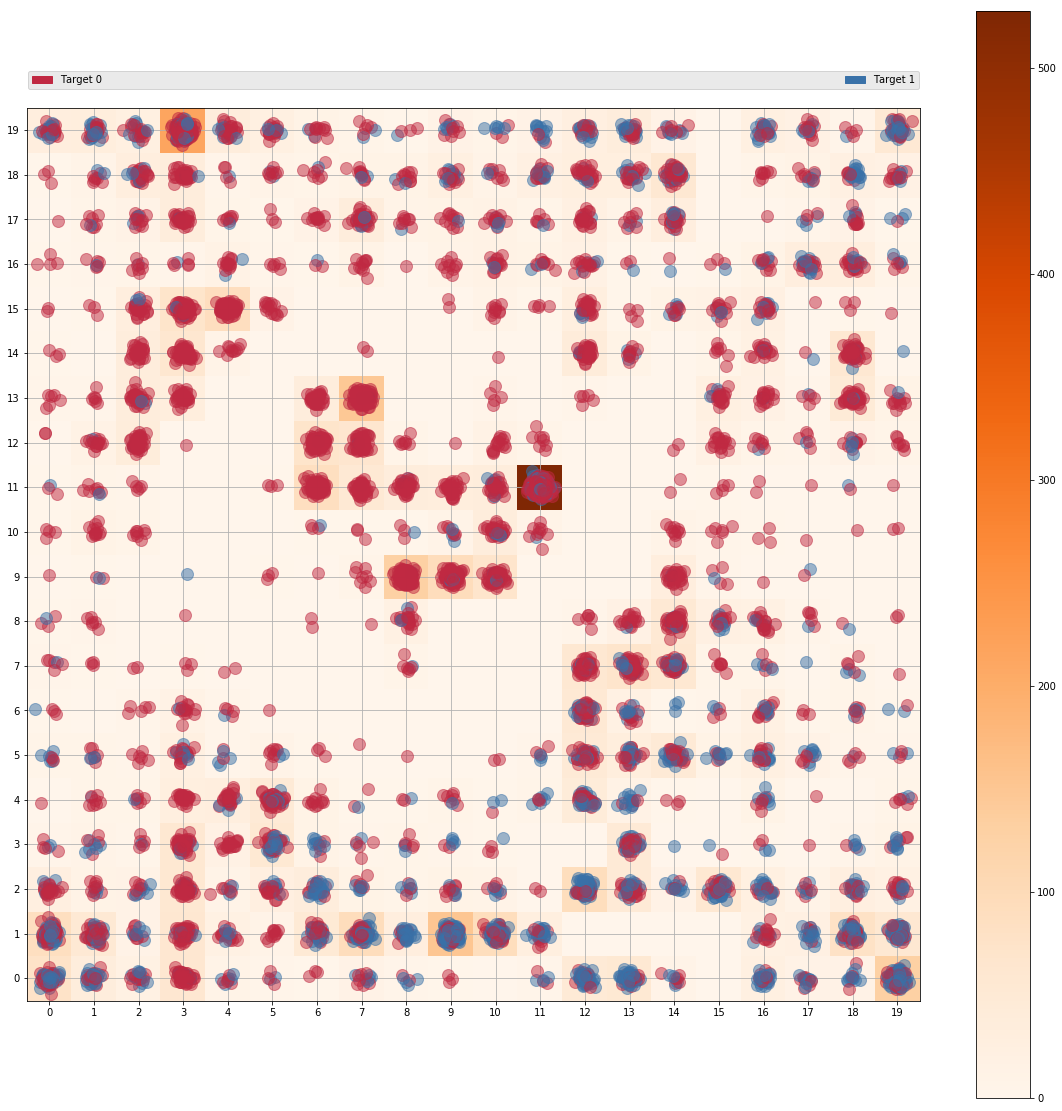

In [24]:
som.plot_point_map(data, target, ['Target 0', 'Target 1'])

And finally visualize the map of every neuron and its distances to all neighbors based on the neuron weights:

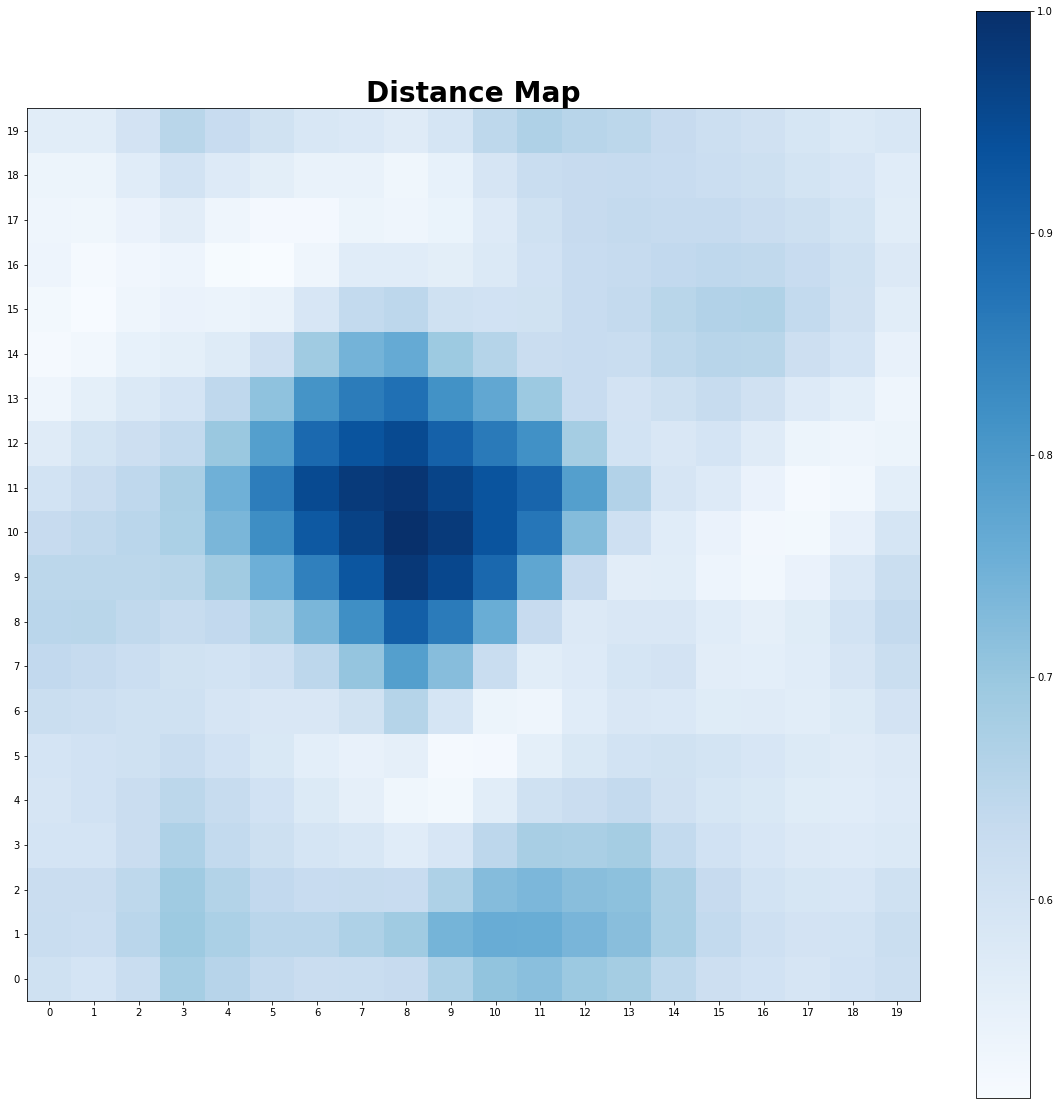

In [25]:
som.plot_distance_map(colormap='Blues')

SOMs can be used for:
- Dimensionality reduction
- Clustering
- Anomaly detection using the Distance Map: for example, all the rows contained in the cluster with the coordinate (6,3) have a MID (Mean Interneuron Distance) very high. This means that are far away from the normal behaviour and, for certain application, we might consider these as fraud.

For this excercise, I will fix them manually: I am going to replace the value of 'TotalCharges' with 0.

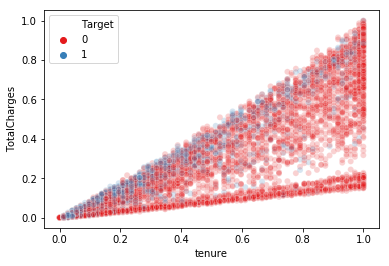

In [23]:
df['TotalCharges'] = np.where(((df['tenure']<0.05) & (df['TotalCharges']>0.2)), 0, df['TotalCharges'])
sns.scatterplot(x='tenure', y='TotalCharges', hue='Target', data=df, palette='Set1', alpha= 0.2)

#### Dimensionality Reduction
The easiest way to undestand the data is a visualization. Unfortunatelly I can't plot any dataset with more than 3 dimensions. I could apply different techniqeus of feature extraction:

- PCA: Principal Component Analysis identifies the combination of components (directions in the feature space) that account for the most variance in the data.
- t-SNE: T-Distributed Stochastic Neighbouring Entities is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. It could potentially lead to better data separation/visualization, because unlike PCA it preserves the local structure of data points.
- UMAP: Uniform Manifold Approximation and Projection is a dimension reduction technique that can be used for visualisation similarly to t-SNE.

I am going to apply these techniques with only 2 dimensions in order create vizualisation to compare their results:

Text(0.5, 1.0, 'UMAP')

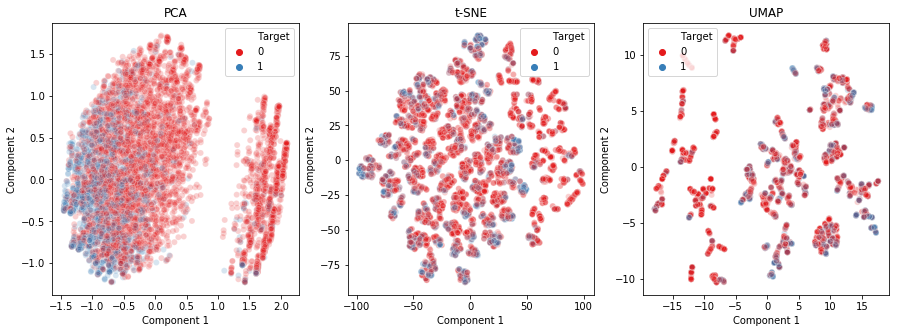

In [27]:
dfs = df.sample(frac=1,random_state=1)
X = dfs.drop(['Target'],axis=1)

feature, axs = plt.subplots(ncols = 3, figsize=(15, 5))

pca_2 = PCA(n_components = 2)
X_pca_2 = pca_2.fit_transform(X)
pca_data = pd.concat([pd.DataFrame(X_pca_2),pd.DataFrame(dfs['Target'].reset_index(drop=True))],axis=1)
pca_data.columns = ['Component 1', 'Component 2', 'Target']
sns.scatterplot(x='Component 1', y='Component 2', hue='Target', data=pca_data, palette='Set1', alpha=0.2, ax=axs[0]).set_title('PCA')

tsne_2 = TSNE(n_components=2, random_state=1)
X_tsne_2 = tsne_2.fit_transform(X)
tsne_data = pd.concat([pd.DataFrame(X_tsne_2),pd.DataFrame(dfs['Target'].reset_index(drop=True))],axis=1)
tsne_data.columns = ['Component 1', 'Component 2', 'Target']
sns.scatterplot(x='Component 1', y='Component 2', hue='Target', data=tsne_data, palette='Set1', alpha=0.2, ax=axs[1]).set_title('t-SNE')

reducer = umap.UMAP(random_state=1)
embedding_2 = reducer.fit_transform(X)
umap_data_2 = pd.concat([pd.DataFrame(embedding_2),pd.DataFrame(dfs['Target'].reset_index(drop=True))],axis=1)
umap_data_2.columns = ['Component 1', 'Component 2', 'Target']
sns.scatterplot(x='Component 1', y='Component 2', hue='Target', data=umap_data_2, palette='Set1', alpha=0.2, ax=axs[2]).set_title('UMAP')

## Silhouette analysis 

I could also use the 2 pricipal components of the t-SNE and perform the Silhouette analysis. This can be used to evaluate the unsupervised analysis and then to choose an optimal value of clusters. It mesures how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

This measure has a range of [-1, 1]. When the coeffiecient near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

For n_clusters = 2 The average silhouette_score is : 0.36
For n_clusters = 3 The average silhouette_score is : 0.381
For n_clusters = 4 The average silhouette_score is : 0.379
For n_clusters = 5 The average silhouette_score is : 0.37
For n_clusters = 6 The average silhouette_score is : 0.364


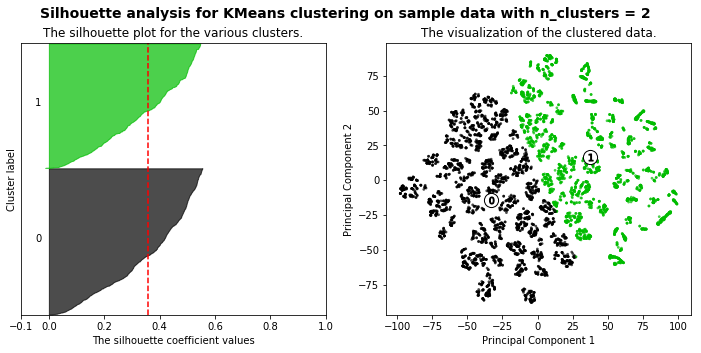

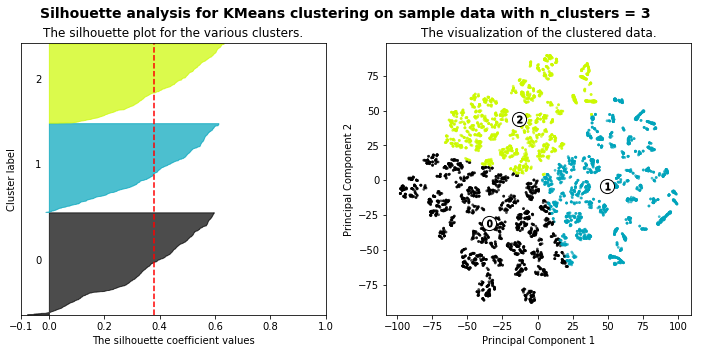

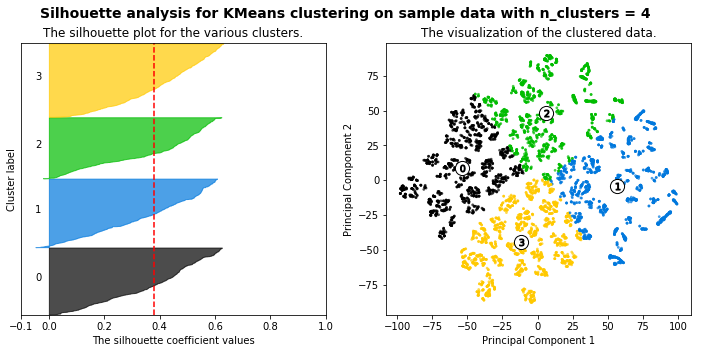

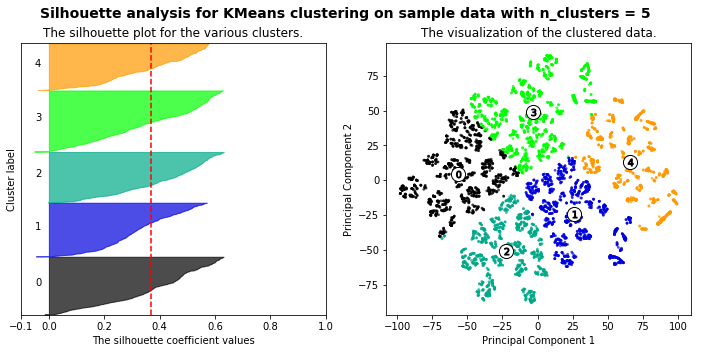

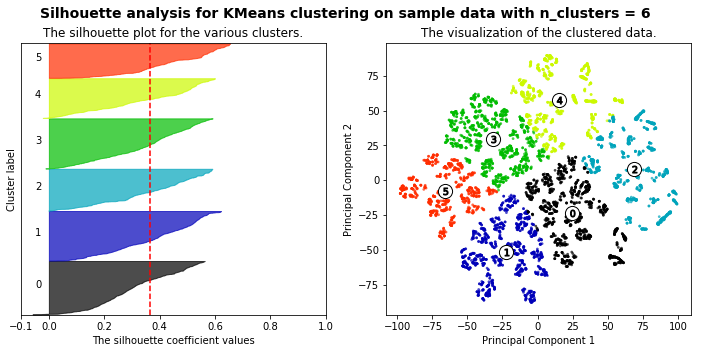

In [28]:
X = X_tsne_2

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples. 
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round((silhouette_avg),3))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Principal Component 1")
    ax2.set_ylabel("Principal Component 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

I can check how much variance is explained using only 2 dimensions in the PCA:

2 Principal Components exaplin 47% of the variance


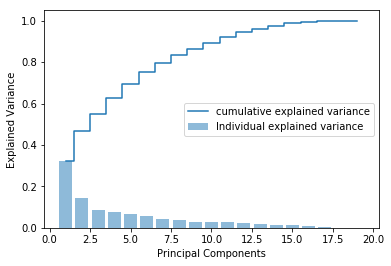

In [24]:
pca = PCA()
pca.fit(df.drop(['Target'],axis=1))
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
cum_var_exp = cumsum[cumsum<0.95]
plt.step(range(1, cumsum.shape[0]+1),cumsum, where= 'mid', label='cumulative explained variance')
plt.bar(range(1, cumsum.shape[0]+1), pca.explained_variance_ratio_, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
print('2 Principal Components exaplin %.0f%% of the variance' %(100*cumsum[1]))
plt.show()

Only 47% of the variance! 2 components are not enough to explain the variance of the dataset, however all the charts above suggested that there are 2 clusters in my data.

#### Clustering Analysis

Choosing the optimal number of clusters with the elbow method:

Text(0.5, 1.0, 'Selecting the optimal k with the Elbow Method')

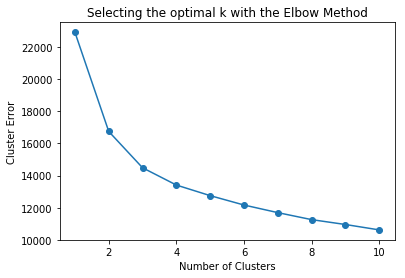

In [25]:
cluster_errors = []
for num_clusters in range(1,11):
    model = KMeans(num_clusters)
    model.fit(df.drop(['Target'],axis=1))
    cluster_errors.append(model.inertia_)
plt.plot(range(1,11), cluster_errors, marker = "o" )
plt.ylabel('Cluster Error')
plt.xlabel('Number of Clusters')
plt.title('Selecting the optimal k with the Elbow Method')

I can also use the hierarchical clustering to analyze this in more details, using the dendrogram. Cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram. Closer it is to 1, the better is the clustering.

In [26]:
cophenets = []
methods = ['single','complete','average','weighted','centroid','median','ward']

for m in methods:
    Z = linkage(df.drop(['Target'],axis=1), metric='euclidean', method=m)
    c, coph_dists = cophenet(Z , pdist(df.iloc[:,:-1]))
    cophenets.append(c)
    
results = pd.concat([pd.DataFrame(methods),pd.DataFrame(cophenets)], axis=1)
results.columns = ['Methods','Cophenet']
results = results.sort_values('Cophenet',ascending=False)
results.reset_index(inplace=True,drop=True)
results

Methods  Cophenet
0   average  0.790150
1  weighted  0.760857
2      ward  0.750036
3  centroid  0.733511
4    median  0.724881
5    single  0.709278
6  complete  0.707212

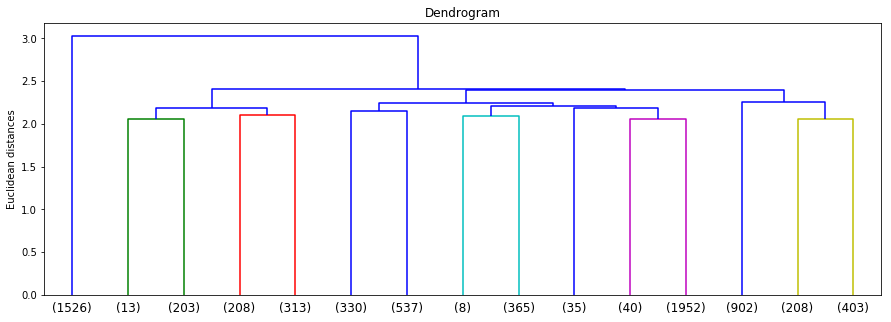

In [27]:
plt.figure(figsize=(15,5))
dendrogram = sch.dendrogram(sch.linkage(df.drop(['Target'],axis=1), method='average'), truncate_mode='lastp', p=15)
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

I can decide the number of optimal clusters by looking at the longest vertical line that doesn't cross any extended horizzontal line. From this, I can confirm that are 2 clusters.

Now let's fit the Hierarchical Clustering to the dataset:

In [28]:
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'average')
df['group'] = hc.fit_predict(df.drop(['Target'],axis=1))

print('There are %.0f records in the group 0 \nThere are %.0f records in the group 1' % (df.groupby('group').count().Target[0],df.groupby('group').count().Target[1]))
print('\n\nGroups Assigned : \n')
df.head()

There are 5517 records in the group 0 
There are 1526 records in the group 1


Groups Assigned : 



gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        0           0  0.569444             1   
1       0              1        0           0  0.916667             1   
2       0              0        0           0  0.166667             1   
3       0              0        0           0  0.069444             1   
4       0              0        1           1  0.138889             1   

   Contract  PaperlessBilling  MonthlyCharges  TotalCharges  ...  \
0       0.5                 1        0.612935      0.381024  ...   
1       1.0                 1        0.837313      0.744640  ...   
2       0.0                 1        0.266169      0.058337  ...   
3       0.0                 1        0.321891      0.026673  ...   
4       0.5                 1        0.474129      0.073996  ...   

   InternetService_target  OnlineSecurity_target  OnlineBackup_target  \
0                0.319901               0.185406             1.000000   
1                1.000000               0.185406             1.000000   
2                0.319901               1.000000             1.000000   
3                0.319901               1.000000             1.000000   
4                0.319901               1.000000             0.411906   

   DeviceProtection_target  TechSupport_target  StreamingTV_target  \
0                 0.472894            0.209794             0.87096   
1                 1.000000            1.000000             0.87096   
2                 1.000000            1.000000             1.00000   
3                 1.000000            1.000000             1.00000   
4                 0.472894            1.000000             1.00000   

   StreamingMovies_target  PaymentMethod_target  Target  group  
0                0.865792              0.052135       0      0  
1                0.865792              0.052135       0      0  
2                1.000000              0.052135       0      0  
3                1.000000              0.124600       1      0  
4                0.865792              0.124600       0      0  

[5 rows x 21 columns]

I can visualize the 2 groups using another time the pairplot:

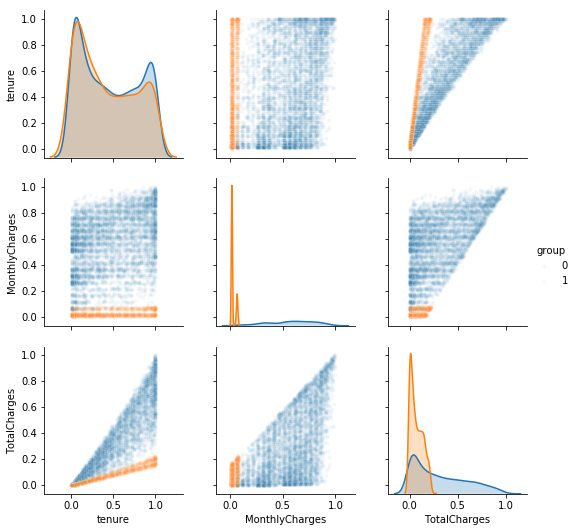

In [29]:
pairplot = sns.pairplot(df,
                        diag_kind='kde',
                        hue='group', 
                        plot_kws={"s": 15,'alpha': 0.05},
                        vars=list(df[numerical_cols].columns))

It worked perfectly! I can also analyze the distribution of the data among the groups. One of the most informative visual tool is boxplot:

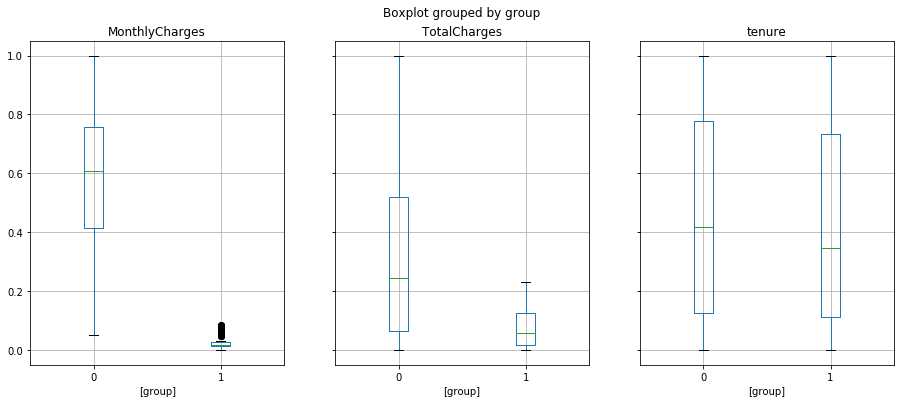

In [31]:
boxplot = df[numerical_cols+['group']].boxplot(by='group', layout=(1,3), figsize=(15,6))

In theory, I should cap the outliers (only on the training set!!!), to get the following results:

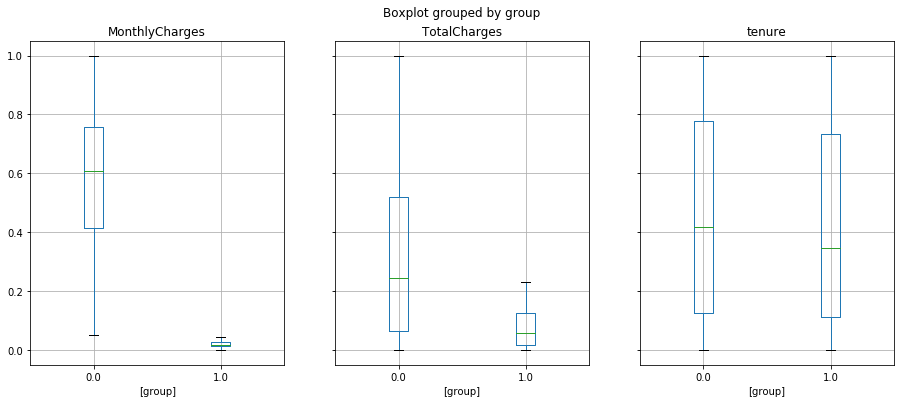

In [41]:
groups = df['group'].unique()
fratures = numerical_cols+['group']
df_outliers = df[numerical_cols+['group']]
for f in fratures:
    for n in groups:
        Q1 = np.percentile(df_outliers[df_outliers['group']==n][f],25)
        Q3 = np.percentile(df_outliers[df_outliers['group']==n][f],75)
        df_outliers.loc[(df_outliers['group']==n) & (df_outliers[f]>Q3+1.5*(Q3-Q1)),f] = Q3+1.5*(Q3-Q1)
        df_outliers.loc[(df_outliers['group']==n) & (df_outliers[f]<Q1-1.5*(Q3-Q1)),f] = Q1-1.5*(Q3-Q1)
        
boxplots = df_outliers.boxplot(by='group', layout=(1,3), figsize=(15,6))

I can visualize the distribution of 'MonthlyCharges':

Text(0.5, 0.98, "'MonthlyCharges' distribution by group")

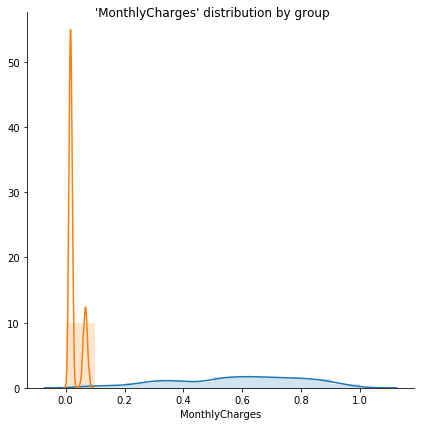

In [42]:
_, bins = np.histogram(df['MonthlyCharges'])
sns.FacetGrid(df, size=6, hue='group').map(sns.distplot, 'MonthlyCharges', bins=bins, hist_kws={'alpha':.2}).fig.suptitle("'MonthlyCharges' distribution by group")

There are 2 spikes in the orange distribution (group 1). I am not going to consider as outliers the data points which belong to the smaller spike, leaving them as they are.

Saving the cleaed dataset:

In [37]:
# df.to_csv('Preprocssed_data.csv')

Loading the saved data:

In [2]:
df = pd.read_csv('Preprocssed_data.csv', index_col=0)

I could also try different combinations (poly, log, sqrt) of the numerical variable to create new features which might be beneficial for the model. I am not goign to use them in this analysis:

In [3]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
poly = PolynomialFeatures(degree = 3, interaction_only=False)
feature_poly = pd.DataFrame(poly.fit_transform(df[numerical_cols]))
feature_poly = feature_poly.iloc[:,1:]
feature_poly_names = []
for i in range(0,feature_poly.shape[1]):
    feature_poly_names.append('poly_'+str(i))
feature_poly = pd.DataFrame(feature_poly)
feature_poly.columns = feature_poly_names
features = df[numerical_cols]
for i in features.columns:
    features['log_'+str(i)] = np.log(features[i]+1) 
    features['sqrt_'+str(i)] = features[i]**1/2
features = features.iloc[:,df[numerical_cols].shape[1]:]
features = pd.concat([feature_poly,features],axis=1)
columns = features.columns.to_list()
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(features))
features.columns = columns
df_test = pd.concat([df,features],axis=1)
df_test.head()

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        0           0  0.569444             1   
1       0              1        0           0  0.916667             1   
2       0              0        0           0  0.166667             1   
3       0              0        0           0  0.069444             1   
4       0              0        1           1  0.138889             1   

   Contract  PaperlessBilling  MonthlyCharges  TotalCharges  ...   poly_15  \
0       0.5                 1        0.612935      0.381024  ...  0.230273   
1       1.0                 1        0.837313      0.744640  ...  0.587035   
2       0.0                 1        0.266169      0.058337  ...  0.018857   
3       0.0                 1        0.321891      0.026673  ...  0.033352   
4       0.5                 1        0.474129      0.073996  ...  0.106584   

    poly_16   poly_17   poly_18  log_tenure  sqrt_tenure  log_MonthlyCharges  \
0  0.143351  0.089239  0.055317    0.650254     0.569444            0.689689   
1  0.522807  0.465607  0.412894    0.938599     0.916667            0.877598   
2  0.004139  0.000908  0.000199    0.222392     0.166667            0.340470   
3  0.002768  0.000230  0.000019    0.096862     0.069444            0.402603   
4  0.016658  0.002603  0.000405    0.187627     0.138889            0.559863   

   sqrt_MonthlyCharges  log_TotalCharges  sqrt_TotalCharges  
0             0.612935          0.465738           0.381024  
1             0.837313          0.802929           0.744640  
2             0.266169          0.081799           0.058337  
3             0.321891          0.037977           0.026673  
4             0.474129          0.102989           0.073996  

[5 rows x 46 columns]

Defining the input space and target:

In [4]:
X = df.drop('Target',axis=1)
y = df['Target']

## Spliting the data in train and test set
I am going to use 70% of data for training and 30% for testing

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=1)
for train_index, test_index in split.split(df, df['Target']):
    train = df.loc[train_index]
    test = df.loc[test_index]

X_train = train.drop(['Target'],axis=1)
X_test = test.drop(['Target'],axis=1)
y_train = train['Target']
y_test = test['Target']

Since I am facing a slightly unbalance problem, I could use the SMOTE package for upsampling the minority class:

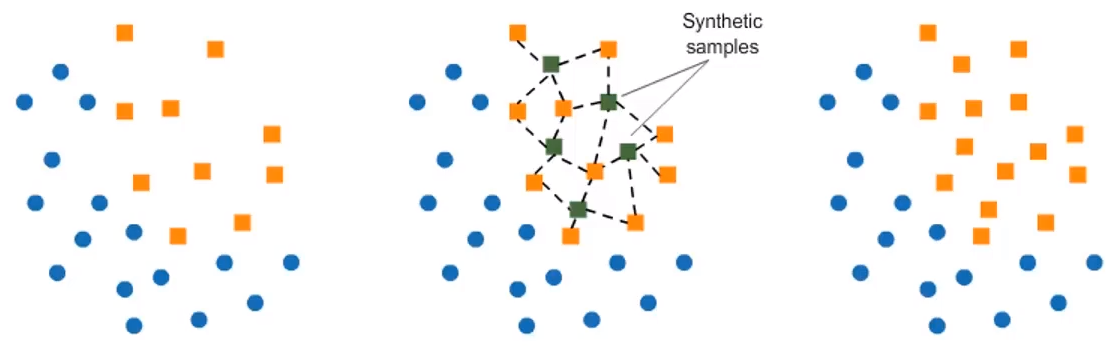

In [6]:
PATH = "C:/Users/diego.bettega/Desktop/Machine Learning/PGP/Projects/Liberty Global/"
Image(filename = PATH + 'SMOTE.png', width=800, height=150)

In [7]:
# smote = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
# X_train, y_train = smote.fit_sample(X_train, y_train.ravel())

print('%.0f records (%.0f%%) are used for training \n%.0f records (%.0f%%) are used for testing' % (len(X_train), (100*len(X_train)/(len(X_train)+len(X_test))), len(test), (100*len(test)/(len(X_train)+len(X_test)))))

5282 records (75%) are used for training 
1761 records (25%) are used for testing


Check 'Target' ratio of the split data. This is a sanity check to assure a correct stratified sampling of the 2 groups: I would like to have similar ratio in the original dataset, training and test set.

In [8]:
df_ratio = pd.DataFrame(round(df.groupby(['Target']).count().iloc[:,0]/len(df),4))
train_ratio = pd.DataFrame(round(train.groupby(['Target']).count().iloc[:,0]/len(train),4))
test_ratio = pd.DataFrame(round(test.groupby(['Target']).count().iloc[:,0]/len(test),4))
Stratified_split = pd.concat([df_ratio,train_ratio,test_ratio],axis=1)
Stratified_split.columns = ['df','train','test']
Stratified_split

df   train    test
Target                        
0       0.7346  0.7346  0.7348
1       0.2654  0.2654  0.2652

We are dealing with an unbalance clafficiation problem: the number of "No" is much higher than "Yes". Because of this, I am going to use AUC as my reference score.

#### KNN

The optimal number of neighbors is 43


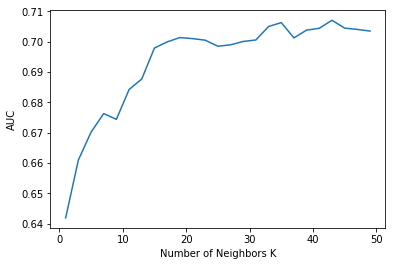

Execution time = 0:00:33.898384


In [9]:
start=datetime.now()

# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold accuracy scores
scores = []

# perform accuracy metrics for values from 1,3,5....19
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scorer = make_scorer(roc_auc_score)
    score = cross_val_score(knn, X_train, y_train, cv=10, scoring=scorer).mean() # evaluate score
    scores.append(score)  

# changing to misclassification error
scores = [x for x in scores]

# determining best k
optimal_k = neighbors[scores.index(max(scores))]
n_neighbors = optimal_k
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('AUC')
plt.show()

stop=datetime.now()
execution_time_knn = stop-start
print('Execution time =',execution_time_knn)

Saving KNN hyperparameters:

In [9]:
optimal_k = 43
knn = KNeighborsClassifier(n_neighbors=optimal_k)

## Randomized search with cross-validation for hyperparameters tuning:

Instead of using grid search, I am going to use RandomizedSearchCV. It allows me to have much more control on the time spent on the tuning and usually it leads to better results.

In [10]:
def tuning(model,parameters,iteration=50,n_folds=10,X_train=X_train,y_train=y_train,scorer=make_scorer(roc_auc_score)):
    """
    Return the best combination of hyperparameters
    model: model to tune
    parameters: grid of hyperparameters
    iteration: number of combinations to try randomly
    n_fold: number of folds used in the cross-validation
    score: specify what is the score/target of the problem
    """
    start1=datetime.now()
    randomCV1 = RandomizedSearchCV(model,
                                   param_distributions=parameters,
                                   n_iter=5,
                                   cv=n_folds,
                                   random_state=1)
    randomCV1.fit(X_train, y_train)
    stop1=datetime.now()
    execution_time1 = stop1-start1
    print('Expected execution time is about',iteration*execution_time1/5,'\n')
    
    start=datetime.now()
    randomCV = RandomizedSearchCV(model,
                                  param_distributions=parameters,
                                  n_iter=iteration,
                                  cv=n_folds,
                                  scoring=scorer,
                                  random_state=1)
    randomCV.fit(X_train, y_train)
    stop=datetime.now()
    execution_time = stop-start
    print('Execution time =',execution_time,'\n')
    print('\nTHE BEST COMBINATION OF HYPERPARAMETERS IS:\n\n',randomCV.best_params_)

#### LOGISTI REGRESSION

In [47]:
param_dist = {'solver': ['newton-cg','lbfgs', 'liblinear','sag','saga']}

tuning(LogisticRegression(random_state=1),param_dist)

Expected execution time is about 0:01:01.032720 

Execution time = 0:00:05.667582 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'solver': 'liblinear'}


Saving Logistic Regression hyperparameters:

In [11]:
logistic_hyperparameters = {'solver': 'liblinear'}

logistic = LogisticRegression(solver=logistic_hyperparameters.get('solver'),
                              random_state=1)

#### SVM

In [ ]:
param_dist = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'C': np.linspace(0.1,10,100),
              'gamma': np.linspace(0.1,10,100)}
tuning(SVC(decision_function_shape='ovo', random_state=1), param_dist, iteration=10,n_folds=5)

Saving SVM hyperparameters:

In [12]:
svm_hyperparameters = {'kernel': 'linear', 
                       'gamma': 4.3999999999999995, 
                       'C': 3.1}

svm = SVC(kernel=svm_hyperparameters.get('kernel'),
          C=svm_hyperparameters.get('C'),
          gamma=svm_hyperparameters.get('gamma'),
          decision_function_shape='ovo',
          probability=True,
          random_state=1)

#### DECISION TREE

In [52]:
param_dist = {'max_depth': sp_randint(1, df.shape[1])}
tuning(DecisionTreeClassifier(),param_dist)

Expected execution time is about 0:00:17.728130 

Execution time = 0:00:18.542296 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'max_depth': 2}


Saving Decision Tree hyperparameters:

In [13]:
dtree_hyperparameters = {'max_depth': 2}

dtree = DecisionTreeClassifier(max_depth=dtree_hyperparameters.get('max_depth'),
                               random_state=1)

#### BAGGING

In [53]:
param_dist = {'n_estimators': sp_randint(10, 500),
              'max_samples': sp_randint(10, 500),
              'oob_score': [True,False]}
tuning(BaggingClassifier(),param_dist)

Expected execution time is about 0:06:49.101130 

Execution time = 0:08:32.462577 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'max_samples': 159, 'n_estimators': 213, 'oob_score': False}


Saving Bagging hyperparameters:

In [14]:
bag_hyperparameters = {'max_samples': 159, 
                       'n_estimators': 213, 
                       'oob_score': False}

bag = BaggingClassifier(n_estimators=bag_hyperparameters.get('n_estimators'),
                        max_samples=bag_hyperparameters.get('max_samples'),
                        oob_score=bag_hyperparameters.get('oob_score'),
                        random_state=1)

#### RANDOM FOREST

In [54]:
param_dist = {'n_estimators': sp_randint(10, 500),
              'max_depth': sp_randint(1, X.shape[1]+1),
              'max_features': sp_randint(1, X.shape[1]+1),
              'min_samples_split': sp_randint(2, X.shape[1]+1),
              'min_samples_leaf': sp_randint(1, X.shape[1]+1),
              'bootstrap': [True, False]}
tuning(RandomForestClassifier(),param_dist)

Expected execution time is about 0:29:42.365360 

Execution time = 0:16:41.995647 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'bootstrap': False, 'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 17, 'min_samples_split': 18, 'n_estimators': 188}


Saving Random Forest hyperparameters:

In [15]:
rf_hyperparameters = {'bootstrap': False, 
                      'max_depth': 7, 
                      'max_features': 7, 
                      'min_samples_leaf': 17, 
                      'min_samples_split': 18, 
                      'n_estimators': 188}

rf = RandomForestClassifier(n_estimators=rf_hyperparameters.get('n_estimators'),
                            max_features=rf_hyperparameters.get('max_features'),
                            max_depth=rf_hyperparameters.get('max_depth'),
                            max_leaf_nodes=rf_hyperparameters.get('max_leaf_nodes'),
                            bootstrap=rf_hyperparameters.get('bootstrap'),
                            random_state=1)

#### ADABOOST

In [55]:
param_dist = {'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,100)}
tuning(AdaBoostClassifier(),param_dist)

Expected execution time is about 0:09:09.923060 

Execution time = 0:11:37.214736 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'learning_rate': 0.64, 'n_estimators': 327}


Saving Adaboost hyperparameters:

In [16]:
ada_hyperparameters = {'learning_rate': 0.64, 
                       'n_estimators': 327}

ada = AdaBoostClassifier(n_estimators=ada_hyperparameters.get('n_estimators'),
                         learning_rate=ada_hyperparameters.get('learning_rate'),
                         random_state=1)

#### XGBOOST

In [81]:
param_dist = {'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,30),
              'max_depth': sp_randint(1, X.shape[1]+1),
              'subsample': [0.5,0.8],
              'colsample_bytree': np.linspace(0.2,1,10),
              'gamma': np.linspace(0.1,5,10),
              'booster': ['dart','gblinear'],
              'objective': ['binary:logistic']
             }
tuning(XGBClassifier(),param_dist)

Expected execution time is about 1:12:46.476050 

Execution time = 0:46:43.923081 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'booster': 'dart', 'colsample_bytree': 0.8222222222222222, 'gamma': 1.188888888888889, 'learning_rate': 0.3513793103448276, 'max_depth': 1, 'n_estimators': 499, 'objective': 'binary:logistic', 'subsample': 0.5}


Saving XGBoost hyperparameters:

In [17]:
xgb_hyperparameters = {'booster': 'dart', 
                       'colsample_bytree': 0.8222222222222222, 
                       'gamma': 1.188888888888889, 
                       'learning_rate': 0.3513793103448276, 
                       'max_depth': 1, 
                       'n_estimators': 499, 
                       'objective': 'binary:logistic', 
                       'subsample': 0.5}

xgb = XGBClassifier(n_estimators=xgb_hyperparameters.get('n_estimators'),
                    learning_rate=xgb_hyperparameters.get('learning_rate'),
                    max_depth=xgb_hyperparameters.get('max_depth'),
                    subsample=xgb_hyperparameters.get('subsample'),
                    colsample_bytree=xgb_hyperparameters.get('colsample_bytree'),
                    gamma=xgb_hyperparameters.get('gamma'),
                    booster=xgb_hyperparameters.get('booster'),
                    random_state=1)

#### LIGHT GBM

I am going to try another model.

In [57]:
param_dist = {'application': ['binary'],
              'objective': ['binary'],
              'feature_fraction': np.linspace(0.3,1,8),
              'erbose_eval': [False,True],
              'booster': ['dart','gbdt'],
              'num_leaves': sp_randint(2, X_train.shape[1]+1),
              'max_depth': sp_randint(1, X_train.shape[1]+1),
              'max_bin': sp_randint(10, 200),
              'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,30)}
tuning(LGBMClassifier(random_state=1),param_dist)

Expected execution time is about 0:04:17.745390 

Execution time = 0:04:00.751447 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'application': 'binary', 'booster': 'gbdt', 'erbose_eval': False, 'feature_fraction': 0.6, 'learning_rate': 0.1806896551724138, 'max_bin': 67, 'max_depth': 20, 'n_estimators': 176, 'num_leaves': 10, 'objective': 'binary'}


Saving Light GBM hyperparameters:

In [18]:
lgbm_hyperparameters = {'application': 'binary', 
                        'booster': 'dart', 
                        'erbose_eval': True, 
                        'feature_fraction': 0.7999999999999999, 
                        'learning_rate': 0.6927586206896552, 
                        'max_bin': 20, 'max_depth': 1, 
                        'n_estimators': 193, 
                        'num_leaves': 9, 
                        'objective': 'binary'}

lgbm = LGBMClassifier(application=lgbm_hyperparameters.get('application'),
                      objective=lgbm_hyperparameters.get('objective'),
                      is_unbalance=lgbm_hyperparameters.get('is_unbalance'),
                      feature_fraction=lgbm_hyperparameters.get('feature_fraction'),
                      bagging_fraction=lgbm_hyperparameters.get('bagging_fraction'),
                      bagging_freq=lgbm_hyperparameters.get('bagging_freq'),
                      verbose=lgbm_hyperparameters.get('verbose'),
                      booster=lgbm_hyperparameters.get('booster'),                  
                      erbose_eval=lgbm_hyperparameters.get('erbose_eval'),
                      num_leaves=lgbm_hyperparameters.get('num_leaves'),
                      max_depth=lgbm_hyperparameters.get('max_depth'),
                      max_bin=lgbm_hyperparameters.get('max_bin'),                      
                      n_estimators=lgbm_hyperparameters.get('n_estimators'),     
                      learning_rate=lgbm_hyperparameters.get('learning_rate'), 
                      random_state=1)

Voting Classifiers:

In [19]:
voting_clf = VotingClassifier(estimators=[
                                          ('KNN', knn),
                                          ('Logistic Regression', logistic),
                                          ('SVM', svm),
                                          ('Decision Tree', dtree), 
                                          ('Bagging', bag), 
                                          ('Random Forest', rf), 
                                          ('Adaboost', ada),  
                                          ('XGBoost', xgb), 
                                          ('Light GBM', lgbm)
                                         ],
                              voting='soft')

#### Artificial Neural Network

I am going to try using keras to build our neural network.

In [20]:
# Initialize the network
keras.backend.clear_session()
network = Sequential()

# Adding the input layer and the first hidden layer
network.add(Dense(output_dim = 15, init = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
network.add(Dropout(0.2))

# Adding the second hidden layer
network.add(Dense(output_dim = 10, init = 'uniform', activation = 'relu'))
network.add(Dropout(0.2))

# Adding the second hidden layer
network.add(Dense(output_dim = 5, init = 'uniform', activation = 'relu'))
network.add(Dropout(0.2))

# Adding the output layer
network.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
network.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [keras.metrics.AUC(num_thresholds=3)])

# Review the network
network.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
________________________________________________

Let's create a visualization of the network

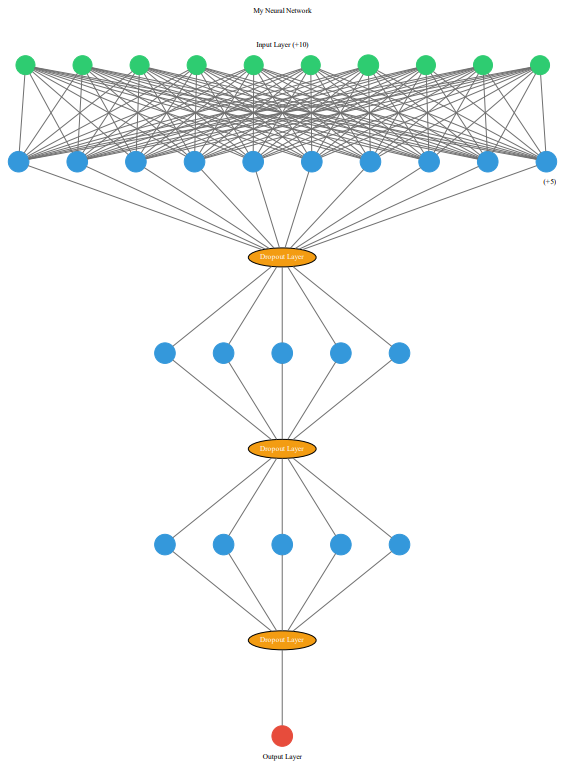

In [81]:
os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Library/bin'
# ann_viz(network)
Image(filename = PATH + 'ANN.png', width=800, height=150)

Defining the list of all the models I need to evaluate:

In [21]:
models_list = [
              {'label': 'KNN','model': knn,},    
              {'label': 'Logistic Regression','model': logistic,},
              {'label': 'SVM','model': svm,},
              {'label': 'Decision Tree','model': dtree,},
              {'label': 'Random Forest','model': rf,},
              {'label': 'Bagging','model': bag,},
              {'label': 'Adaboost','model': ada,},
              {'label': 'XGBoost','model': xgb,}, 
              {'label': 'Light GBM','model': lgbm,},
              {'label': 'Voting Classifier','model': voting_clf,},
              {'label': 'ANN','model': network,}
              ]

Defining 2 functions to evaluate the models:

In [64]:
def models_evaluation(models=models_list,
                      df=df,
                      iterations=1,
                      test_size=0.25,
                      classification_report=False,
                      ROC=True,
                      ROC_size=[15,10],
                      Hist=True,
                      Hist_size=[15,5],
                      alpha = 0.95,
                      stacking_chart=True):
    """
    Return the summary report for every model contained in the 'models' list and a ROC curve chart to visually compare all the models
    """
    
    AUCs = []
    FPRs =[]
    TPRs = []
    Models = []
    y_tests_master = []
    y_preds_master = []
    y_preds_proba_master = []
    AUCs_chart_master = []
    EXECUTION_TIMES_TRAINING = []
    EXECUTION_TIMES_TESTING = []

    for m in range(0,len(models)):
        
        X_tests_proba = []
        X_trains_proba = []
        y_trains = []
        y_tests = []
        y_preds = []
        y_preds_proba = []
        y_preds_train = []
        AUCs_chart = []
        
        model = models[m].get('model')

        for i in range(1,iterations+1):
            split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=i)
            for train_index, test_index in split.split(df, df['Target']):
                train = df.loc[train_index]
                test = df.loc[test_index]
            X_train = train.drop(['Target'],axis=1)
            X_test = test.drop(['Target'],axis=1)
            y_train = train['Target']
            y_test = test['Target']
           
            y_trains = np.concatenate((y_trains,y_train), axis=0)
            y_tests = np.concatenate((y_tests,y_test), axis=0)
            
            if model==network:
                start_training=datetime.now()
                history = model.fit(X_train, y_train, batch_size=10, nb_epoch=10, validation_split=0.25, verbose=0)
                stop_training=datetime.now()
                y_pred = model.predict(X_test)
                y_pred_proba = y_pred
                y_pred = np.where((y_pred > 0.5), 1, 0)
                AUC_chart = round(metrics.roc_auc_score(y_test, y_pred_proba),4)
                AUCs_chart.append(AUC_chart)
                y_preds = np.concatenate((y_preds,y_pred.reshape(len(y_pred),)), axis=0)
                y_preds_proba = np.concatenate((y_preds_proba,y_pred_proba.reshape(len(y_pred_proba),)), axis=0)
                X_tests_proba = np.concatenate((X_tests_proba,np.array(model.predict_proba(X_test)).reshape(len(X_test),)),axis=0)
                stop_testing=datetime.now()
                y_pred_train = model.predict(X_train)
                y_pred_train = np.where((y_pred_train > 0.5), 1, 0)
                y_preds_train = np.concatenate((y_preds_train,y_pred_train.reshape(len(y_pred_train),)), axis=0)
                X_trains_proba = np.concatenate((X_trains_proba,np.array(model.predict_proba(X_train)).reshape(len(X_train),)),axis=0)
            else:
                start_training=datetime.now()
                model.fit(X_train, y_train)
                stop_training=datetime.now()
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:,1]
                AUC_chart = round(metrics.roc_auc_score(y_test, y_pred_proba),4)
                AUCs_chart.append(AUC_chart)
                y_preds = np.concatenate((y_preds,y_pred), axis=0)
                y_preds_proba = np.concatenate((y_preds_proba,y_pred_proba), axis=0)
                X_tests_proba = np.concatenate((X_tests_proba, y_pred_proba), axis=0)
                stop_testing=datetime.now()
                y_pred_train = model.predict(X_train)
                y_preds_train = np.concatenate((y_preds_train,y_pred_train), axis=0)
                X_trains_proba = np.concatenate((X_trains_proba,model.predict_proba(X_train)[:,1]), axis=0)
            
            execution_time_training = (stop_training-start_training).total_seconds()
            execution_time_testing = (stop_testing-stop_training).total_seconds()
            if i==1:
                execution_times_training = execution_time_training
                execution_times_testing = execution_time_testing               
            else:
                execution_times_training = execution_times_training + execution_time_training
                execution_times_testing = execution_times_testing + execution_time_testing

        y_tests_master.append(y_tests)  
        y_preds_master.append(y_preds) 
        y_preds_proba_master.append(y_preds_proba)               
        AUCs_chart_master.append(AUCs_chart)        
        EXECUTION_TIMES_TRAINING.append(round((execution_times_training/iterations),3))
        EXECUTION_TIMES_TESTING.append(round((execution_times_testing/iterations),3))

        a = round(metrics.accuracy_score(y_tests, y_preds),4)
        a_train = round(metrics.accuracy_score(y_trains, y_preds_train),4)
        p = round(metrics.precision_score(y_tests, y_preds),4)
        p_train = round(metrics.precision_score(y_trains, y_preds_train),4)
        r = round(metrics.recall_score(y_tests, y_preds),4)
        r_train = round(metrics.recall_score(y_trains, y_preds_train),4)
        f = round(metrics.f1_score(y_tests, y_preds),4)
        f_train = round(metrics.f1_score(y_trains, y_preds_train),4)
        auc = round(metrics.roc_auc_score(y_tests, X_tests_proba),4)
        auc_train = round(metrics.roc_auc_score(y_trains, X_trains_proba),4)
        fpr, tpr, thresholds = metrics.roc_curve(y_tests, X_tests_proba)
        print('\nMODEL:', models[m].get('label'),'\n')
        print('TRAINING execution time =',round((execution_times_training/iterations),3))
        print('TESTING execution time =',round((execution_times_testing/iterations),3),'\n')
        if classification_report==True:
            print('\nAveraged Classification Report:\n')
            print(metrics.classification_report(pd.DataFrame(y_tests).sample(frac=(1/iterations),random_state=1), 
                                                pd.DataFrame(y_preds).sample(frac=(1/iterations),random_state=1), 
                                                digits=4))
        print('\nComparison for class 1 between Training and Test set:')
        print('\nAccuracy = %0.4f  (%0.4f on Training)'% (a,a_train))  
        print('Precision = %0.4f  (%0.4f on Training)'% (p,p_train)) 
        print('Recall = %0.4f  (%0.4f on Training)'% (r,r_train)) 
        print('F1 = %0.4f  (%0.4f on Training)'% (f,f_train)) 
        print('AUC = %0.4f  (%0.4f on Training)'% (auc,auc_train)) 
        
        
        if iterations==1:
            cm = metrics.confusion_matrix(y_tests,y_preds,[1,0])
            cm = cm/cm.sum()
            sns.heatmap(cm, 
                        annot=True,  
                        annot_kws={'size': 15},
                        fmt='.1%', 
                        xticklabels = ["1", "0"], 
                        yticklabels = ["1", "0"], 
                        linecolor='white',
                        cmap='YlGnBu')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()
        else:
            feature, axs = plt.subplots(ncols = 2, figsize=(15, 3))
            sns.distplot(AUCs_chart, kde=True, ax=axs[0]).set_title('Average AUCs = %.4f \nStandard Deviation = %.4f' %((sum(AUCs_chart)/float(len(AUCs_chart))), np.sqrt(np.var(AUCs_chart))))
            cm = metrics.confusion_matrix(y_tests,y_preds,[1,0])
            cm = cm/cm.sum()
            sns.heatmap(cm, 
                        annot=True,  
                        annot_kws={'size': 15},
                        fmt='.1%', 
                        xticklabels = ["1", "0"], 
                        yticklabels = ["1", "0"], 
                        linecolor='white',
                        cmap='YlGnBu',
                        ax=axs[1])
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

            
    #     if model==network:
    #         # list all data in history
    #         # print(history.history.keys())
    #         # summarize history for loss
    #         plt.plot(history.history['loss'])
    #         plt.plot(history.history['val_loss'])
    #         plt.title('model loss')
    #         plt.ylabel('loss')
    #         plt.xlabel('epoch')
    #         plt.legend(['train', 'test'], loc='upper left')
    #         plt.show()

        AUCs.append(auc)
        FPRs.append(fpr)
        TPRs.append(tpr)
        Models.append(models[m].get('label'))
        print('\n##################################################################################################\n')  
    
    #ROC Curves
    if ROC==True:
        plt.figure(figsize=(ROC_size[0],ROC_size[1]))
        for m in range(0,len(models)):
            plt.plot(FPRs[m], TPRs[m], label='%s AUC = %0.4f' % (models[m].get('label'), AUCs[m]))
        # Custom settings for the plot 
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Specificity (False Positive Rate)')
        plt.ylabel('Sensitivity (True Positive Rate)')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show() 

    execution_data = pd.concat([pd.DataFrame(Models),pd.DataFrame(AUCs, dtype=float),pd.DataFrame(EXECUTION_TIMES_TRAINING),pd.DataFrame(EXECUTION_TIMES_TESTING)],axis=1)
    execution_data.columns = ('Model','AUC','Training (sec)', 'Testing (sec)')
    execution_data = execution_data.sort_values('AUC',ascending=False)
    execution_data.reset_index(inplace=True,drop=True)
    execution_data.set_index('Model', inplace=True)
    print(execution_data)
    
    if iterations>1 and Hist==True:
        # Hist Charts                    
        p = 100*((1.0-alpha)/2.0) 
        plt.figure(figsize=(Hist_size[0],Hist_size[1]))
        for m in range(0,len(models)):
            sns.distplot(AUCs_chart_master[m], hist=False, label='%s AUC = %0.4f'  %(models[m].get('label'), AUCs[m]))  
        plt.xlabel('AUC')
        plt.legend(loc = 'best')
        plt.show()
        print('I am %.0f%% confident that the AUC of the model in production will be:\n' % (alpha*100))
        for m in range(0,len(models)):
            lower = max(0.0, np.percentile(AUCs_chart_master[m], p))  
            upper = max(0.0, np.percentile(AUCs_chart_master[m], 100-p))
            print('%s: between %.3f and %.3f' % (models[m].get('label'), lower, upper))
        print('\n\n')
            
    if iterations>1 and len(models_list)>1 and stacking_chart==True:
        errors = pd.DataFrame(y_preds_proba_master).transpose()
        errors = pd.concat([pd.DataFrame(y_tests_master[0]),errors],axis=1)
        columns = ['test']
        for m in range(0,len(models_list)):
            columns.append(models_list[m].get('label'))
        errors.columns = columns
        for c in range(1,len(columns)):
            errors[columns[c]] = np.where((errors[columns[c]] > 0.5), 1, 0)
        Tot_errors = errors.iloc[:,1:].sum() 
        for c in range(1,len(columns)):
            errors[columns[c]] = np.where((errors[columns[c]]==errors[columns[0]]), 0, 1)
        errors['Tot errors'] = errors.drop([columns[0]],axis=1).sum(axis=1)
        errors = errors[errors['Tot errors']>0]
        for c in range(1,len(columns)):
            errors[columns[c]] = errors[columns[c]]/errors['Tot errors']
        errors = errors.drop(['test','Tot errors'],axis=1)
        standardize_errors = (errors.sum()/Tot_errors)
        standardize_errors = pd.DataFrame(standardize_errors.reset_index())
        standardize_errors.columns = ['Model','Indipendent Error Rate']
        standardize_errors = standardize_errors.sort_values(by='Indipendent Error Rate', ascending=False)
        plt.figure(figsize=(Hist_size[0],Hist_size[1]))
        bar_plot = sns.barplot(y='Indipendent Error Rate', x='Model', data=standardize_errors).set_title('Best models for Stacking')
        plt.xticks(rotation=45)
        plt.show()

Evaluation of all the models contained in 'models_list':


MODEL: KNN 

TRAINING execution time = 0.018
TESTING execution time = 0.538 


Comparison for class 1 between Training and Test set:

Accuracy = 0.7871  (0.7963 on Training)
Precision = 0.6102  (0.6314 on Training)
Recall = 0.5460  (0.5591 on Training)
F1 = 0.5763  (0.5931 on Training)
AUC = 0.8225  (0.8405 on Training)


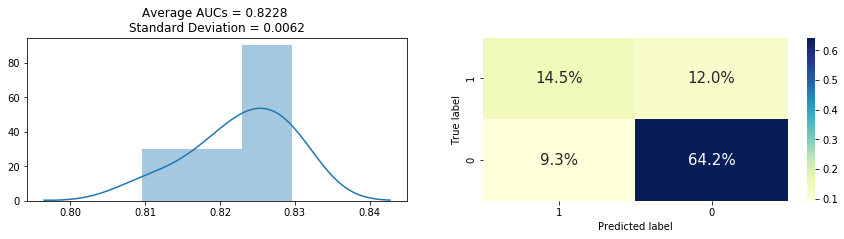


##################################################################################################


MODEL: Logistic Regression 

TRAINING execution time = 0.022
TESTING execution time = 0.003 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8057  (0.8042 on Training)
Precision = 0.6617  (0.6578 on Training)
Recall = 0.5467  (0.5466 on Training)
F1 = 0.5987  (0.5970 on Training)
AUC = 0.8456  (0.8475 on Training)


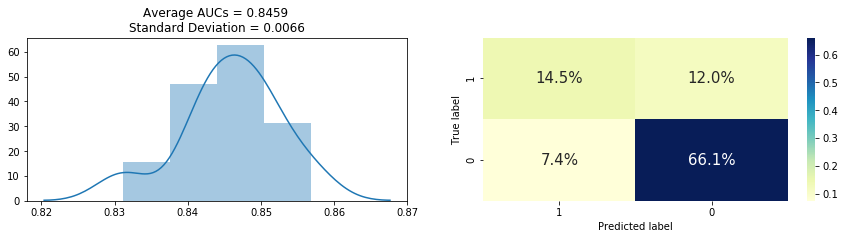


##################################################################################################


MODEL: SVM 

TRAINING execution time = 3.233
TESTING execution time = 0.163 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8026  (0.8001 on Training)
Precision = 0.6555  (0.6498 on Training)
Recall = 0.5383  (0.5352 on Training)
F1 = 0.5912  (0.5870 on Training)
AUC = 0.8357  (0.8377 on Training)


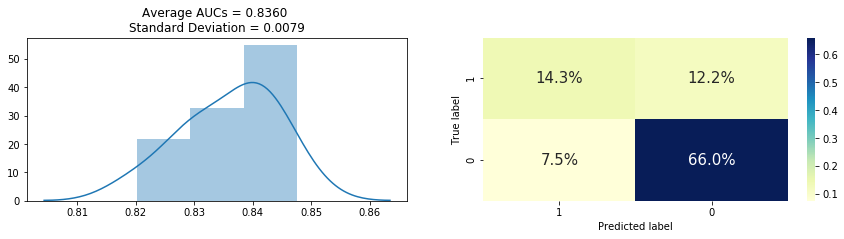


##################################################################################################


MODEL: Decision Tree 

TRAINING execution time = 0.006
TESTING execution time = 0.003 


Comparison for class 1 between Training and Test set:

Accuracy = 0.7600  (0.7606 on Training)
Precision = 0.5407  (0.5421 on Training)
Recall = 0.6313  (0.6315 on Training)
F1 = 0.5825  (0.5834 on Training)
AUC = 0.7870  (0.7930 on Training)


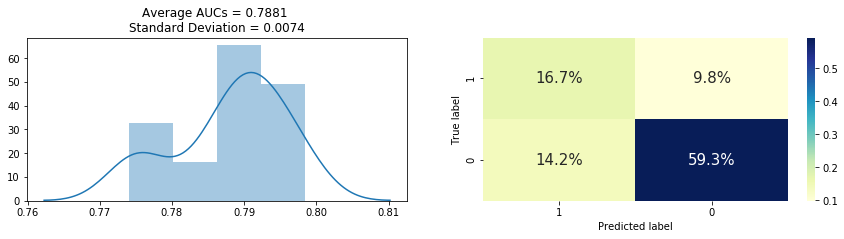


##################################################################################################


MODEL: Random Forest 

TRAINING execution time = 1.045
TESTING execution time = 0.092 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8030  (0.8336 on Training)
Precision = 0.6648  (0.7364 on Training)
Recall = 0.5186  (0.5810 on Training)
F1 = 0.5827  (0.6495 on Training)
AUC = 0.8460  (0.9031 on Training)


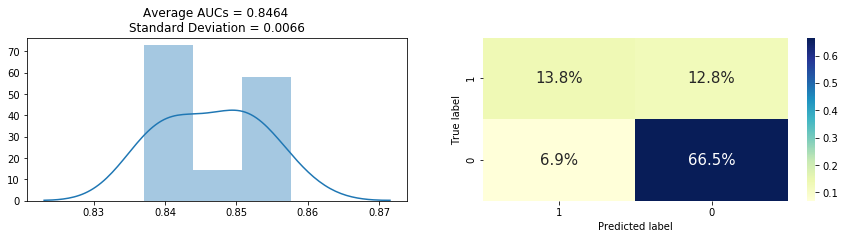


##################################################################################################


MODEL: Bagging 

TRAINING execution time = 0.32
TESTING execution time = 0.109 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8033  (0.8159 on Training)
Precision = 0.6729  (0.7050 on Training)
Recall = 0.5026  (0.5271 on Training)
F1 = 0.5754  (0.6032 on Training)
AUC = 0.8444  (0.8673 on Training)


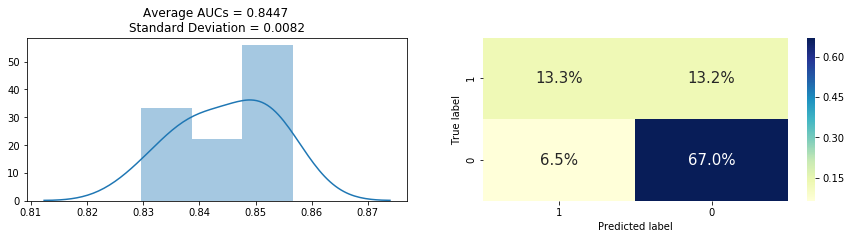


##################################################################################################


MODEL: Adaboost 

TRAINING execution time = 1.334
TESTING execution time = 0.165 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8034  (0.8147 on Training)
Precision = 0.6589  (0.6854 on Training)
Recall = 0.5362  (0.5577 on Training)
F1 = 0.5913  (0.6150 on Training)
AUC = 0.8428  (0.8682 on Training)


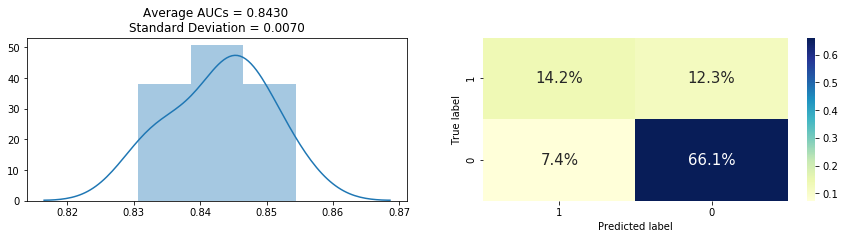


##################################################################################################


MODEL: XGBoost 

TRAINING execution time = 8.355
TESTING execution time = 0.025 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8019  (0.8196 on Training)
Precision = 0.6568  (0.6975 on Training)
Recall = 0.5302  (0.5658 on Training)
F1 = 0.5867  (0.6248 on Training)
AUC = 0.8442  (0.8710 on Training)


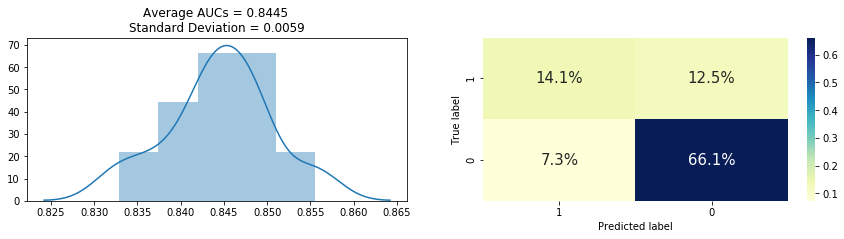


##################################################################################################


MODEL: Light GBM 

TRAINING execution time = 0.091
TESTING execution time = 0.027 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8051  (0.8106 on Training)
Precision = 0.6645  (0.6784 on Training)
Recall = 0.5355  (0.5449 on Training)
F1 = 0.5931  (0.6044 on Training)
AUC = 0.8486  (0.8581 on Training)


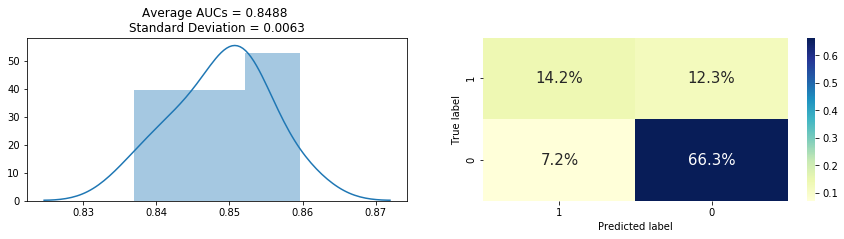


##################################################################################################


MODEL: Voting Classifier 

TRAINING execution time = 14.259
TESTING execution time = 1.267 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8083  (0.8163 on Training)
Precision = 0.6784  (0.6982 on Training)
Recall = 0.5268  (0.5424 on Training)
F1 = 0.5931  (0.6105 on Training)
AUC = 0.8488  (0.8680 on Training)


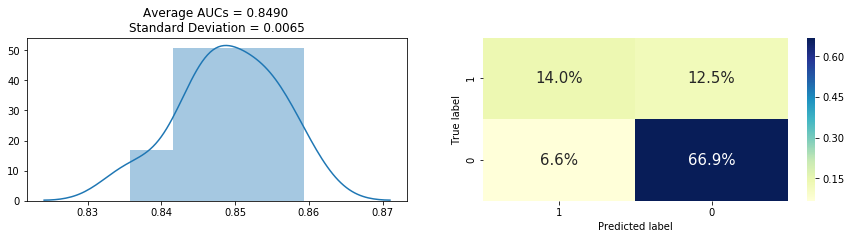


##################################################################################################

Instructions for updating:
Use tf.cast instead.

MODEL: ANN 

TRAINING execution time = 4.506
TESTING execution time = 0.038 


Comparison for class 1 between Training and Test set:

Accuracy = 0.7884  (0.7886 on Training)
Precision = 0.6674  (0.6681 on Training)
Recall = 0.4030  (0.4045 on Training)
F1 = 0.5025  (0.5039 on Training)
AUC = 0.8358  (0.8388 on Training)


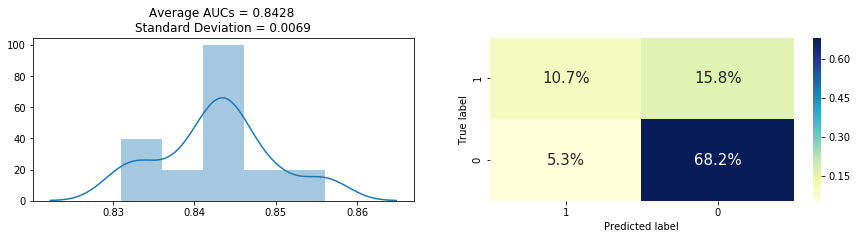


##################################################################################################



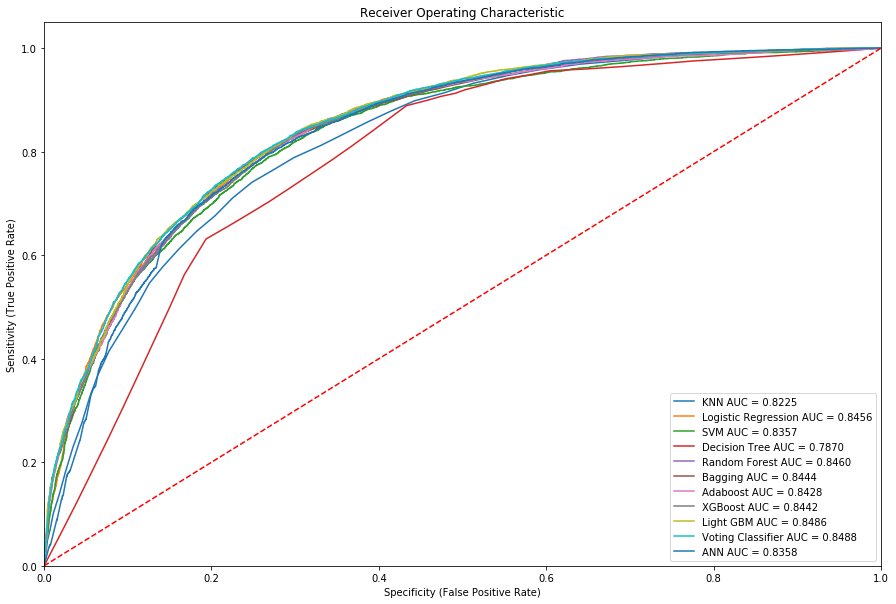

                        AUC  Training (sec)  Testing (sec)
Model                                                     
Voting Classifier    0.8488          14.259          1.267
Light GBM            0.8486           0.091          0.027
Random Forest        0.8460           1.045          0.092
Logistic Regression  0.8456           0.022          0.003
Bagging              0.8444           0.320          0.109
XGBoost              0.8442           8.355          0.025
Adaboost             0.8428           1.334          0.165
ANN                  0.8358           4.506          0.038
SVM                  0.8357           3.233          0.163
KNN                  0.8225           0.018          0.538
Decision Tree        0.7870           0.006          0.003


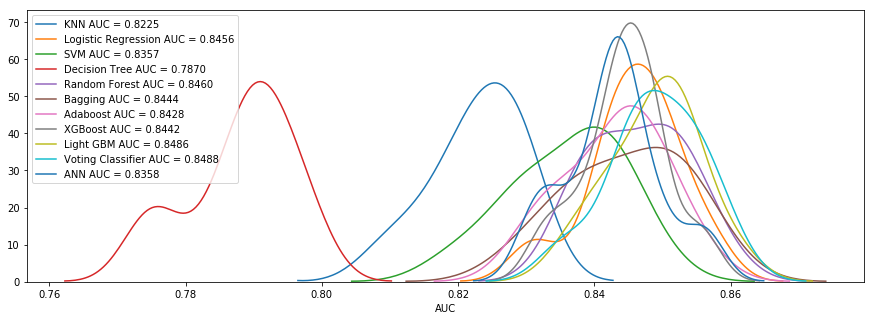

I am 95% confident that the AUC of the model in production will be:

KNN: between 0.811 and 0.830
Logistic Regression: between 0.833 and 0.856
SVM: between 0.822 and 0.847
Decision Tree: between 0.775 and 0.798
Random Forest: between 0.837 and 0.857
Bagging: between 0.831 and 0.856
Adaboost: between 0.831 and 0.853
XGBoost: between 0.834 and 0.854
Light GBM: between 0.838 and 0.858
Voting Classifier: between 0.837 and 0.859
ANN: between 0.832 and 0.855





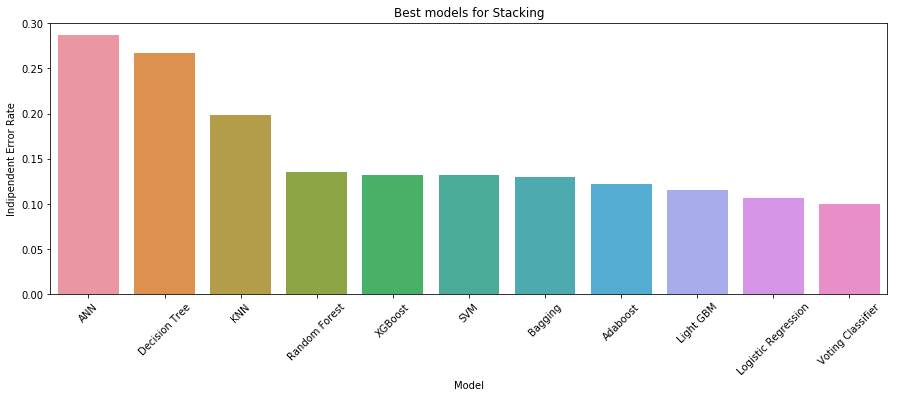

In [23]:
models_evaluation(models=models_list, iterations=10)

The last chart is a representation of how many indipendent errors the models are making. This information might be useful to cmbine different models: I don't want to combine together different models if they are making the same mistakes!

#### Stacking

Its name stand for stacked generalization. It is based on a simple idea: instead of using trivial functions (such as soft voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation?

In [ ]:
Image(filename = PATH + 'stacking.png', width=500, height=150)

I am going to use 4 models for the first layer:
- ANN
- Decision Tree
- KNN
- Random Forest
- XGBoost

In [24]:
stacking = [
              {'label': 'KNN','model': knn,},    
#               {'label': 'Logistic Regression','model': logistic,},
#               {'label': 'SVM','model': svm,},
              {'label': 'Decision Tree','model': dtree,},
              {'label': 'Random Forest','model': rf,},
#               {'label': 'Bagging','model': bag,},
#               {'label': 'Adaboost','model': ada,},
              {'label': 'XGBoost','model': xgb,}, 
#               {'label': 'Light GBM','model': lgbm,},
#               {'label': 'Voting Classifier','model': voting_clf,},
              {'label': 'ANN','model': network,}
           ]

I need to undestand how much data I need.

Epoch 1/1
352/352 [==============================] - ETA: 0s - loss: 0.4971 - auc_1: 0.666 - 0s 51us/step - loss: 0.4482 - auc_1: 0.7043
Epoch 1/1
704/704 [==============================] - ETA: 0s - loss: 0.4904 - auc_1: 0.562 - 0s 54us/step - loss: 0.4576 - auc_1: 0.7267
Epoch 1/1
1056/1056 [==============================] - ETA: 0s - loss: 0.3255 - auc_1: 0.859 - 0s 40us/step - loss: 0.4514 - auc_1: 0.7047
Epoch 1/1
1409/1409 [==============================] - ETA: 0s - loss: 0.3225 - auc_1: 0.857 - ETA: 0s - loss: 0.4461 - auc_1: 0.690 - 0s 53us/step - loss: 0.4491 - auc_1: 0.7001
Epoch 1/1
1761/1761 [==============================] - ETA: 0s - loss: 0.3749 - auc_1: 0.833 - ETA: 0s - loss: 0.4592 - auc_1: 0.709 - 0s 43us/step - loss: 0.4523 - auc_1: 0.7100
Epoch 1/1
2113/2113 [==============================] - ETA: 0s - loss: 0.6344 - auc_1: 0.725 - ETA: 0s - loss: 0.4753 - auc_1: 0.707 - 0s 43us/step - loss: 0.4686 - auc_1: 0.7088
Epoch 1/1
2465/2465 [=============================

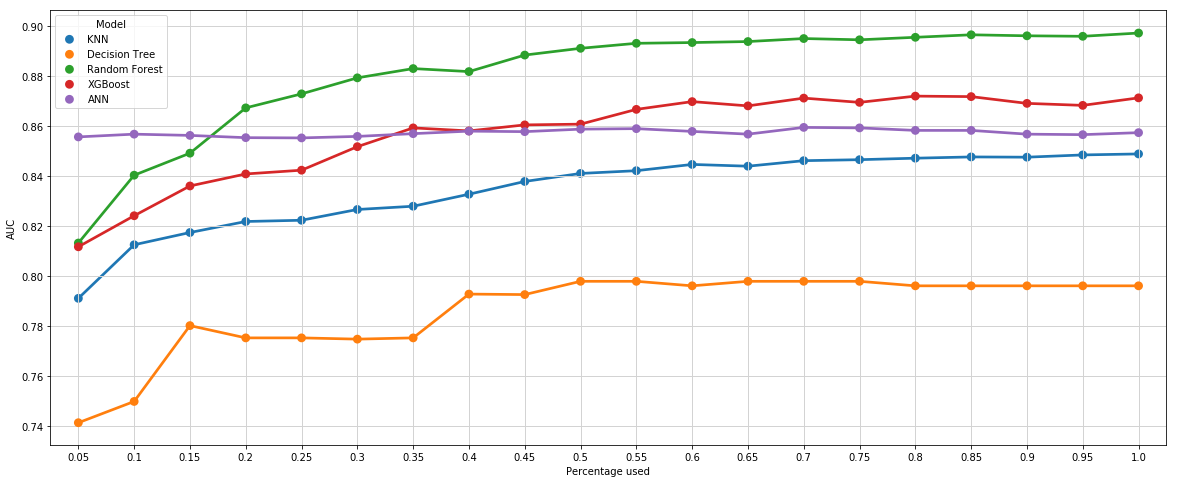

In [26]:
training_percentage = np.linspace(0.05,1,20)

AUCs = []
model_name = []

for m in range(0,len(stacking)):
    
    AUC = []
    model = stacking[m].get('model')
    model_name.append(stacking[m].get('label'))
    
    for i in training_percentage:

        df_sample = df.sample(frac=i,random_state=1)
        X_train_sample = df_sample.drop(['Target'],axis=1)
        y_train_sample = df_sample['Target'] 

        model.fit(X_train_sample, y_train_sample)
        if stacking[m].get('label')=='ANN':
            auc = round(metrics.roc_auc_score(y_test, model.predict_proba(X_test)),4)
        else:
            auc = round(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),4)
        AUC.append(auc)

    AUCs.append(AUC)

stacking_summary = pd.DataFrame(data=AUCs, columns=training_percentage)
stacking_summary = stacking_summary.set_index([model_name])
stacking_summary = stacking_summary.stack().reset_index()
stacking_summary.columns = ['Model','Percentage used','AUC']
stacking_summary = round(stacking_summary,4)
plt.figure(figsize=(20,8))
ax = sns.pointplot(x='Percentage used', y='AUC', hue='Model',data=stacking_summary)
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.show()

There is an elbow at 40% of the dataset. I am going to use 40% of the data for training the first layers. Then I am going to add the 4 predictions (one for each model) to the remaining training data and the test data. Finally I am going to use again all the models for the final prediction.

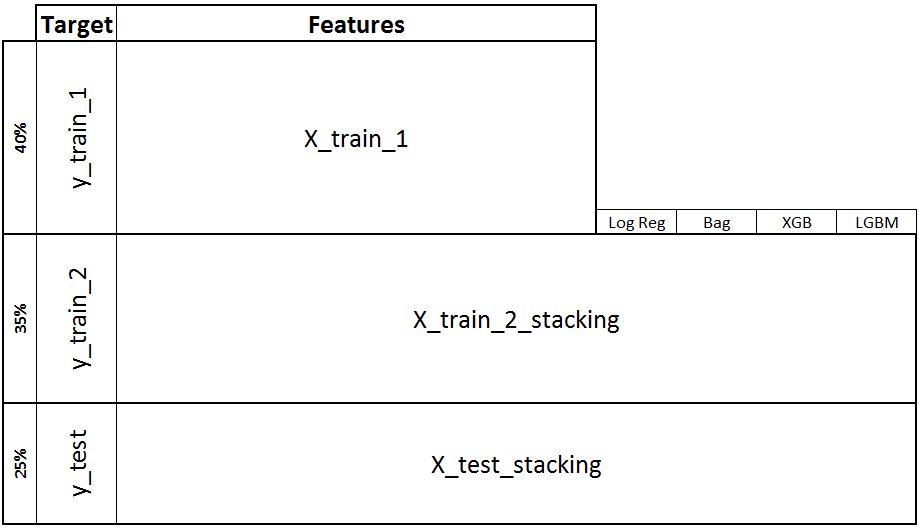

In [27]:
Image(filename = PATH + "Stacking_schema.png", width=500, height=100)

First, I am going to create the different sets:

In [28]:
split = StratifiedShuffleSplit(n_splits=1, test_size=(0.35/0.75), random_state=1)
for train_index_1, test_index_1 in split.split(train, train['Target']):
    train_1 = df.loc[train_index_1]
    train_1.reset_index(inplace=True, drop=True)
    test_1 = df.loc[test_index_1]
    test_1.reset_index(inplace=True, drop=True)
        
X_train_1 = train_1.drop(['Target'],axis=1)
X_train_2 = test_1.drop(['Target'],axis=1)
y_train_1 = train_1['Target']
y_train_2 = test_1['Target']

Generate the extra features fo both X_train_2 and X_test:

In [29]:
X_train_2_stacking = X_train_2.copy()
X_test_stacking = X_test.copy()
X_test_stacking.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

for m in range(0,len(stacking)):
    model = stacking[m].get('model')
    model.fit(X_train_1, y_train_1)
    
    # Add new columns for X_train_2
    if stacking[m].get('label')=='ANN':
        y_pred = model.predict_proba(X_train_2)
    else:    
        y_pred = model.predict_proba(X_train_2)[:,1]
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = [stacking[m].get('label')]
    X_train_2_stacking = pd.concat([X_train_2_stacking,y_pred],axis=1)
    
    # Add new columns for X_test
    if stacking[m].get('label')=='ANN':
        y_pred = model.predict_proba(X_test)
    else:
        y_pred = model.predict_proba(X_test)[:,1]
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = [stacking[m].get('label')]
    X_test_stacking = pd.concat([X_test_stacking,y_pred],axis=1)

X_train_2_stacking.head()

Epoch 1/1
2817/2817 [==============================] - ETA: 0s - loss: 0.3823 - auc_1: 0.900 - ETA: 0s - loss: 0.4756 - auc_1: 0.706 - ETA: 0s - loss: 0.4745 - auc_1: 0.687 - 0s 52us/step - loss: 0.4665 - auc_1: 0.6976


gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       1              0        0           0  0.194444             1   
1       1              0        0           0  0.097222             1   
2       1              1        0           0  0.111111             1   
3       1              0        1           1  0.791667             1   
4       1              0        0           1  0.027778             1   

   Contract  PaperlessBilling  MonthlyCharges  TotalCharges  ...  \
0       0.5                 0        0.021393      0.029645  ...   
1       0.0                 1        0.325871      0.038686  ...   
2       0.0                 0        0.816418      0.093878  ...   
3       1.0                 0        0.024876      0.127435  ...   
4       0.0                 0        0.021393      0.002781  ...   

   TechSupport_target  StreamingTV_target  StreamingMovies_target  \
0            0.000000             0.00000                0.000000   
1            1.000000             1.00000                1.000000   
2            0.209794             0.87096                0.865792   
3            0.000000             0.00000                0.000000   
4            0.000000             0.00000                0.000000   

   PaymentMethod_target  group       KNN  Decision Tree  Random Forest  \
0              0.052135      1  0.069767       0.035673       0.035785   
1              0.124600      0  0.372093       0.265096       0.232705   
2              0.000000      0  0.348837       0.550459       0.707536   
3              0.124600      1  0.000000       0.035673       0.010960   
4              0.124600      1  0.186047       0.265096       0.125706   

    XGBoost       ANN  
0  0.095474  0.035464  
1  0.210758  0.337378  
2  0.446550  0.428319  
3  0.005703  0.000949  
4  0.098693  0.177069  

[5 rows x 25 columns]

Sanity check of the different sets:

In [30]:
print('There are %0.f records in the X_train_1 (%0.0f%%)'% (len(X_train_1),(100*len(X_train_1)/len(df)))) 
print('There are %0.f records in the X_train_2_stacking (%0.0f%%)'% (len(X_train_2_stacking),(100*len(X_train_2_stacking)/len(df))))
print('There are %0.f records in the X_test_stacking (%0.0f%%)'% (len(X_test_stacking),(100*len(X_test_stacking)/len(df)))) 

There are 2817 records in the X_train_1 (40%)
There are 2465 records in the X_train_2_stacking (35%)
There are 1761 records in the X_test_stacking (25%)


Normalaze the 2 input sets:

In [31]:
columns = X_train_2_stacking.columns.to_list()
X_train_2_stacking = pd.DataFrame(scaler.fit_transform(X_train_2_stacking))
X_train_2_stacking.columns = columns
X_test_stacking = pd.DataFrame(scaler.fit_transform(X_test_stacking))
X_test_stacking.columns = columns

Create the dataset for the evaluation:

In [32]:
df_stacking = pd.concat([pd.concat([X_train_2_stacking,y_train_2],axis=1),pd.concat([X_test_stacking,y_test],axis=1)],axis=0).reset_index(drop=True)

Redefining the ANN because noe there are 24 features:

In [33]:
# Initialize the network
keras.backend.clear_session()

# Initialising the ANN
network = Sequential()

# Adding the input layer and the first hidden layer
network.add(Dense(output_dim = 15, init = 'uniform', activation = 'relu', input_dim = X_train_2_stacking.shape[1]))

# Adding the second hidden layer
network.add(Dense(output_dim = 5, init = 'uniform', activation = 'relu'))

# Adding the second hidden layer
network.add(Dense(output_dim = 5, init = 'uniform', activation = 'relu'))

# Adding the output layer
network.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
network.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [keras.metrics.AUC(num_thresholds=3)])

# Review the network
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________


Redefining the list of all the models I need to evaluate:

In [34]:
models_list = [
              {'label': 'KNN','model': knn,},    
              {'label': 'Logistic Regression','model': logistic,},
              {'label': 'SVM','model': svm,},
              {'label': 'Decision Tree','model': dtree,},
              {'label': 'Random Forest','model': rf,},
              {'label': 'Bagging','model': bag,},
              {'label': 'Adaboost','model': ada,},
              {'label': 'XGBoost','model': xgb,}, 
              {'label': 'Light GBM','model': lgbm,},
              {'label': 'Voting Classifier','model': voting_clf,},
              {'label': 'ANN','model': network,}
              ]

I am supposed to tune the hyperparameters again. I will skip this step and use the hyperparameters I found previously.

Evaluation of all the models contained in 'models_list':


MODEL: KNN 

TRAINING execution time = 0.008
TESTING execution time = 0.286 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8109  (0.8126 on Training)
Precision = 0.6584  (0.6628 on Training)
Recall = 0.5838  (0.5877 on Training)
F1 = 0.6189  (0.6230 on Training)
AUC = 0.8520  (0.8614 on Training)


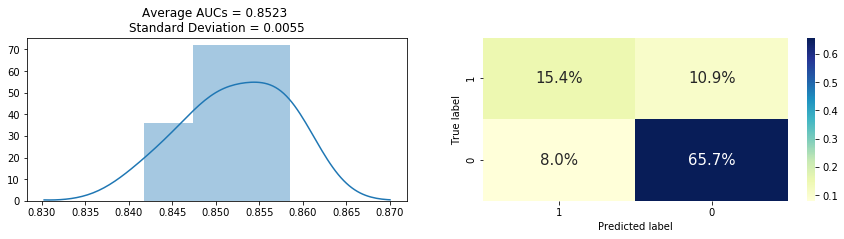


##################################################################################################


MODEL: Logistic Regression 

TRAINING execution time = 0.015
TESTING execution time = 0.003 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8240  (0.8220 on Training)
Precision = 0.6984  (0.6948 on Training)
Recall = 0.5824  (0.5783 on Training)
F1 = 0.6352  (0.6312 on Training)
AUC = 0.8676  (0.8696 on Training)


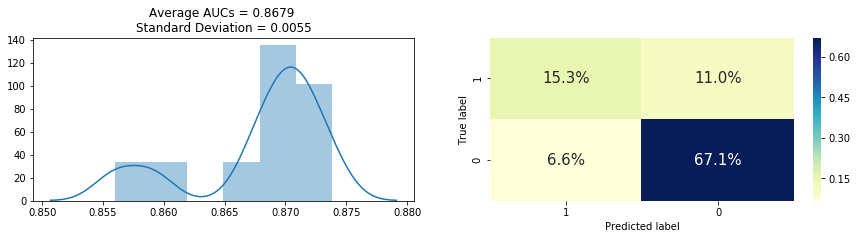


##################################################################################################


MODEL: SVM 

TRAINING execution time = 1.192
TESTING execution time = 0.063 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8163  (0.8159 on Training)
Precision = 0.6866  (0.6875 on Training)
Recall = 0.5547  (0.5525 on Training)
F1 = 0.6136  (0.6126 on Training)
AUC = 0.8515  (0.8540 on Training)


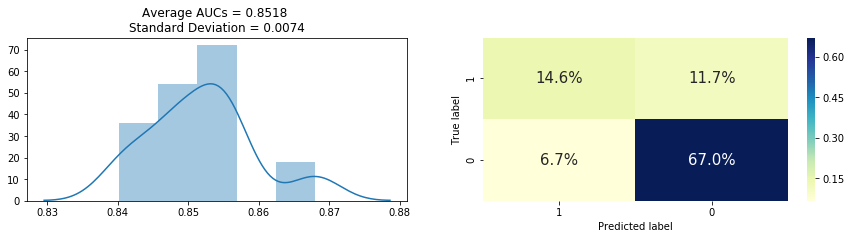


##################################################################################################


MODEL: Decision Tree 

TRAINING execution time = 0.006
TESTING execution time = 0.003 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8003  (0.8041 on Training)
Precision = 0.6086  (0.6169 on Training)
Recall = 0.6745  (0.6764 on Training)
F1 = 0.6398  (0.6453 on Training)
AUC = 0.8414  (0.8487 on Training)


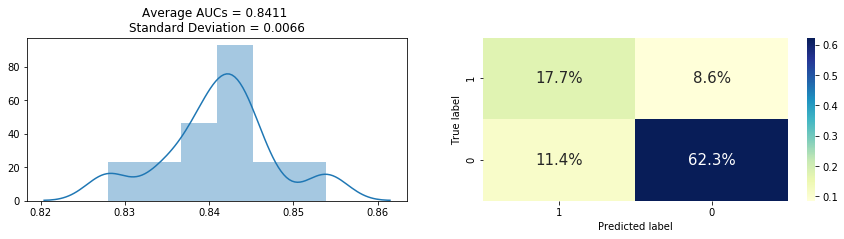


##################################################################################################


MODEL: Random Forest 

TRAINING execution time = 0.993
TESTING execution time = 0.066 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8289  (0.8917 on Training)
Precision = 0.7166  (0.8553 on Training)
Recall = 0.5777  (0.7091 on Training)
F1 = 0.6397  (0.7754 on Training)
AUC = 0.8817  (0.9509 on Training)


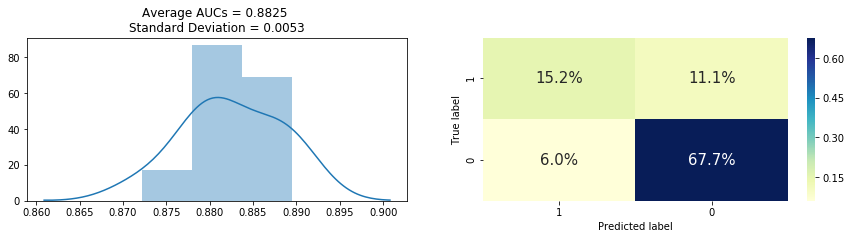


##################################################################################################


MODEL: Bagging 

TRAINING execution time = 0.327
TESTING execution time = 0.082 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8221  (0.8344 on Training)
Precision = 0.7013  (0.7291 on Training)
Recall = 0.5640  (0.5911 on Training)
F1 = 0.6252  (0.6529 on Training)
AUC = 0.8714  (0.8973 on Training)


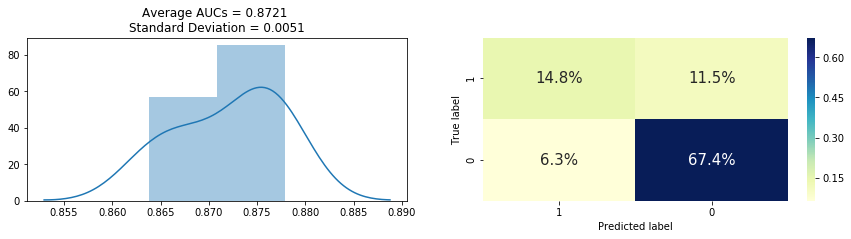


##################################################################################################


MODEL: Adaboost 

TRAINING execution time = 1.257
TESTING execution time = 0.123 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8184  (0.8407 on Training)
Precision = 0.6844  (0.7318 on Training)
Recall = 0.5748  (0.6244 on Training)
F1 = 0.6248  (0.6739 on Training)
AUC = 0.8673  (0.9101 on Training)


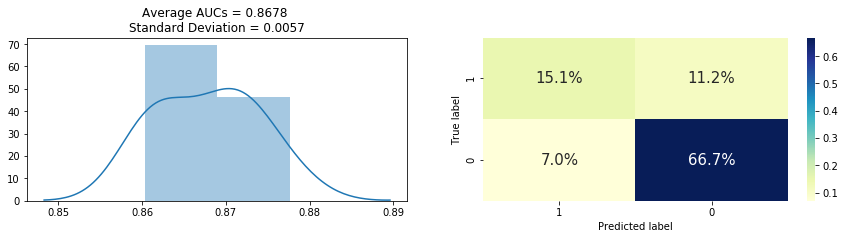


##################################################################################################


MODEL: XGBoost 

TRAINING execution time = 4.887
TESTING execution time = 0.016 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8198  (0.8550 on Training)
Precision = 0.6905  (0.7698 on Training)
Recall = 0.5705  (0.6417 on Training)
F1 = 0.6248  (0.6999 on Training)
AUC = 0.8681  (0.9159 on Training)


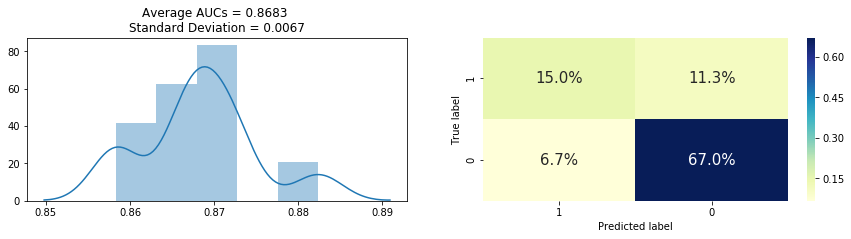


##################################################################################################


MODEL: Light GBM 

TRAINING execution time = 0.069
TESTING execution time = 0.026 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8237  (0.8296 on Training)
Precision = 0.7033  (0.7163 on Training)
Recall = 0.5705  (0.5851 on Training)
F1 = 0.6300  (0.6441 on Training)
AUC = 0.8702  (0.8883 on Training)


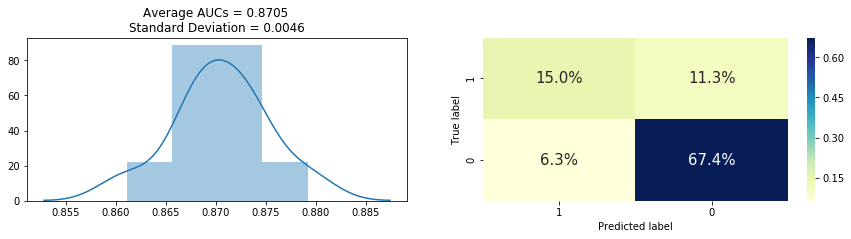


##################################################################################################


MODEL: Voting Classifier 

TRAINING execution time = 12.938
TESTING execution time = 0.889 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8254  (0.8377 on Training)
Precision = 0.7094  (0.7369 on Training)
Recall = 0.5691  (0.5976 on Training)
F1 = 0.6315  (0.6600 on Training)
AUC = 0.8765  (0.9020 on Training)


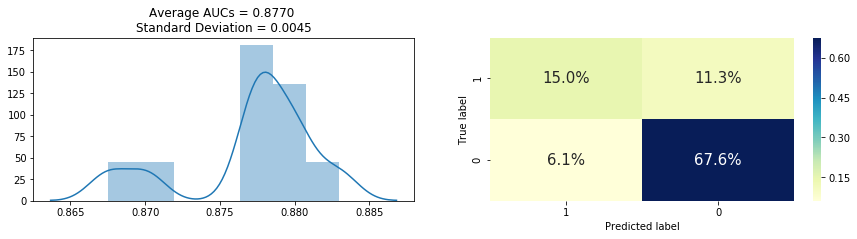


##################################################################################################


MODEL: ANN 

TRAINING execution time = 3.808
TESTING execution time = 0.037 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8222  (0.8211 on Training)
Precision = 0.6889  (0.6883 on Training)
Recall = 0.5910  (0.5867 on Training)
F1 = 0.6362  (0.6334 on Training)
AUC = 0.8662  (0.8680 on Training)


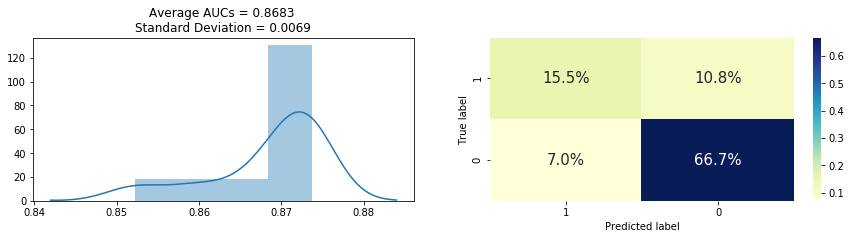


##################################################################################################



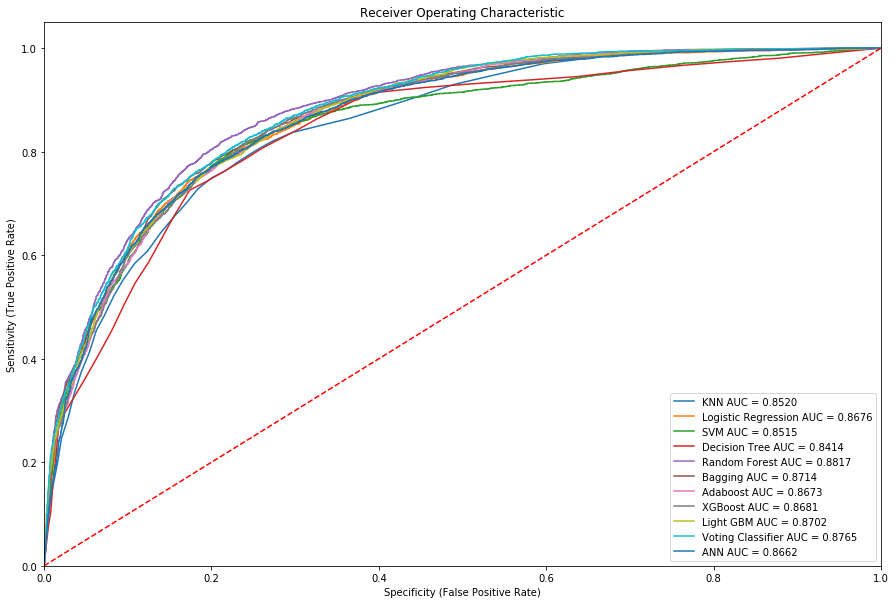

                        AUC  Training (sec)  Testing (sec)
Model                                                     
Random Forest        0.8817           0.993          0.066
Voting Classifier    0.8765          12.938          0.889
Bagging              0.8714           0.327          0.082
Light GBM            0.8702           0.069          0.026
XGBoost              0.8681           4.887          0.016
Logistic Regression  0.8676           0.015          0.003
Adaboost             0.8673           1.257          0.123
ANN                  0.8662           3.808          0.037
KNN                  0.8520           0.008          0.286
SVM                  0.8515           1.192          0.063
Decision Tree        0.8414           0.006          0.003


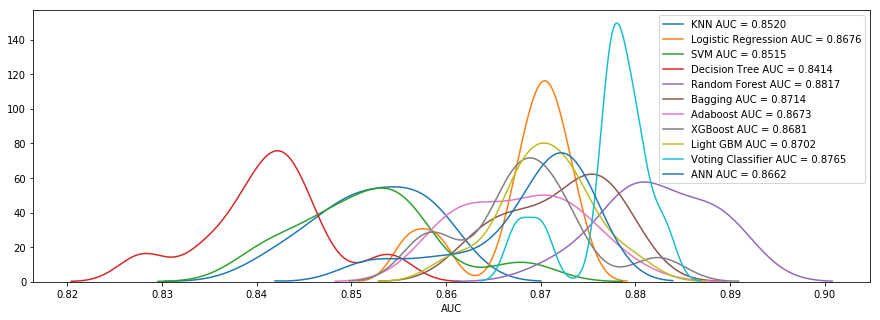

I am 95% confident that the AUC of the model in production will be:

KNN: between 0.843 and 0.859
Logistic Regression: between 0.857 and 0.873
SVM: between 0.841 and 0.865
Decision Tree: between 0.829 and 0.852
Random Forest: between 0.874 and 0.889
Bagging: between 0.864 and 0.878
Adaboost: between 0.860 and 0.876
XGBoost: between 0.858 and 0.880
Light GBM: between 0.863 and 0.878
Voting Classifier: between 0.868 and 0.882
ANN: between 0.854 and 0.874





In [35]:
models_evaluation(models=models_list, df=df_stacking, iterations=10, stacking_chart=False)

We had a big jump: Random Forest is model with the highest AUC!

If I want to predict the likelihood of belonging to the 'Target' category, I can use the predict_proba method. Please note that not all the classifiers have the predict_proba method.

In [36]:
predicted_prob = pd.concat([y_test.reset_index(), round(pd.DataFrame(rf.predict_proba(X_test_stacking))[1],4)],axis=1)
predicted_prob.columns = ['ID','Target','Predicted likelihood Target']
predicted_prob = predicted_prob.set_index('ID')
predicted_prob.head()

Target  Predicted likelihood Target
ID                                     
0        1                       0.6387
1        0                       0.0034
2        0                       0.1561
3        1                       0.5780
4        0                       0.0767

Logidtic Regression performed very well and very fast even without stacking. Please find below the statistic summary of the model:

In [37]:
#Build the logistic regression model
logit = sm.Logit(y_train, sm.add_constant(X_train))
lg = logit.fit()

#Summary of logistic regression
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
print(lg.summary())

Optimization terminated successfully.
         Current function value: 0.415943
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 5282
Model:                          Logit   Df Residuals:                     5261
Method:                           MLE   Df Model:                           20
Date:                Thu, 05 Dec 2019   Pseudo R-squ.:                  0.2812
Time:                        16:32:57   Log-Likelihood:                -2197.0
converged:                       True   LL-Null:                       -3056.5
                                        LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       8.8462      6.527      1.355      0.175      -3.947   

Calculate Odds Ratio and probability:

In [38]:
# Create a data frame to collate Odds ratio, probability and p-value of the coef
lgcoef = pd.DataFrame(lg.params, columns=['coef'])
lgcoef.loc[:, "Odds_ratio"] = np.exp(lgcoef.coef)
lgcoef['probability'] = lgcoef['Odds_ratio']/(1+lgcoef['Odds_ratio'])
lgcoef['pval']=lg.pvalues
pd.options.display.float_format = '{:.2f}'.format

# Filter by significant p-value (pval <0.01) and sort descending by Odds ratio
lgcoef = lgcoef.sort_values(by="Odds_ratio", ascending=False)
pval_filter = lgcoef['pval']<=0.01
lgcoef = lgcoef.sort_values('pval',ascending=True)
lgcoef[pval_filter]

coef  Odds_ratio  probability  pval
Contract             -1.49        0.22         0.18  0.00
tenure               -4.06        0.02         0.02  0.00
PaperlessBilling      0.33        1.40         0.58  0.00
TotalCharges          2.56       12.98         0.93  0.00
PaymentMethod_target  0.31        1.36         0.58  0.00
SeniorCitizen         0.25        1.29         0.56  0.01

I can select these 6 important features and train a new model:

In [58]:
df_reduced = pd.concat([df[lgcoef[pval_filter].index.tolist()],y],axis=1)
df_reduced.head()

Contract  tenure  PaperlessBilling  TotalCharges  PaymentMethod_target  \
0      0.50    0.57                 1          0.38                  0.05   
1      1.00    0.92                 1          0.74                  0.05   
2      0.00    0.17                 1          0.06                  0.05   
3      0.00    0.07                 1          0.03                  0.12   
4      0.50    0.14                 1          0.07                  0.12   

   SeniorCitizen  Target  
0              0       0  
1              1       0  
2              0       0  
3              0       1  
4              0       0

Evaluation of all the Logistic Regression on the reduced dataset:


MODEL: Logistic Regression 

TRAINING execution time = 0.014
TESTING execution time = 0.004 


Comparison for class 1 between Training and Test set:

Accuracy = 0.7852  (0.7830 on Training)
Precision = 0.6435  (0.6360 on Training)
Recall = 0.4259  (0.4270 on Training)
F1 = 0.5126  (0.5110 on Training)
AUC = 0.8289  (0.8298 on Training)


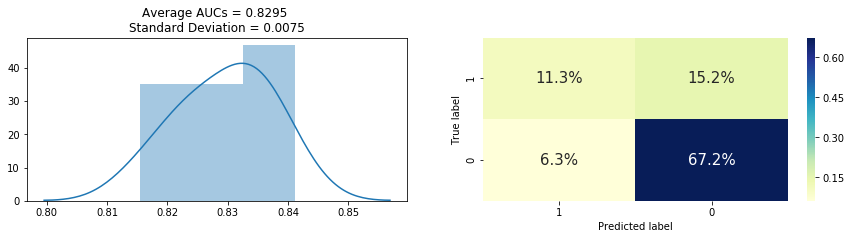


##################################################################################################

                     AUC  Training (sec)  Testing (sec)
Model                                                  
Logistic Regression 0.83            0.01           0.00


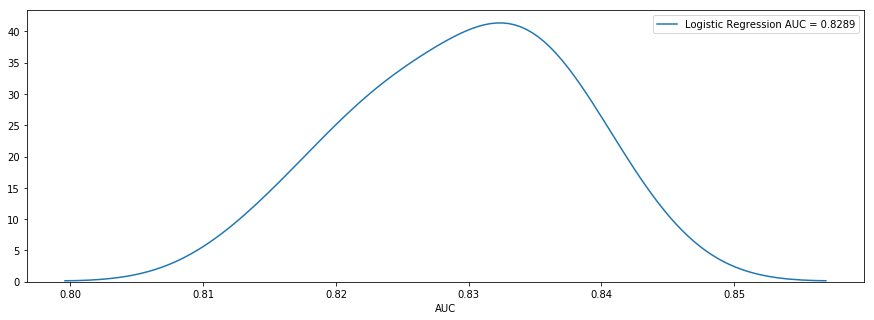

I am 95% confident that the AUC of the model in production will be:

Logistic Regression: between 0.817 and 0.840





In [66]:
models_list = [{'label': 'Logistic Regression','model': logistic,}]

models_evaluation(models=models_list, 
                  df=df_reduced,
                  iterations=10,
                  ROC=False)

And now let's compare with the best model:


MODEL: Random Forest 

TRAINING execution time = 1.176
TESTING execution time = 0.1 


Comparison for class 1 between Training and Test set:

Accuracy = 0.8289  (0.8917 on Training)
Precision = 0.7166  (0.8553 on Training)
Recall = 0.5777  (0.7091 on Training)
F1 = 0.6397  (0.7754 on Training)
AUC = 0.8817  (0.9509 on Training)


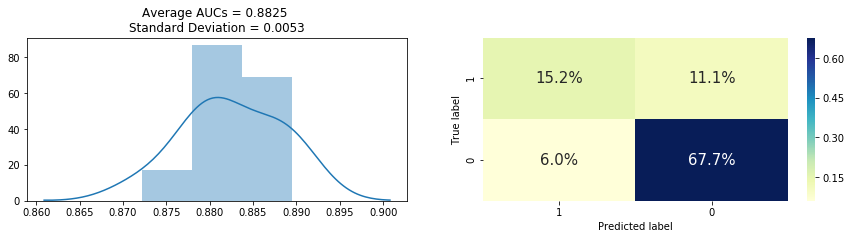


##################################################################################################

               AUC  Training (sec)  Testing (sec)
Model                                            
Random Forest 0.88            1.18           0.10


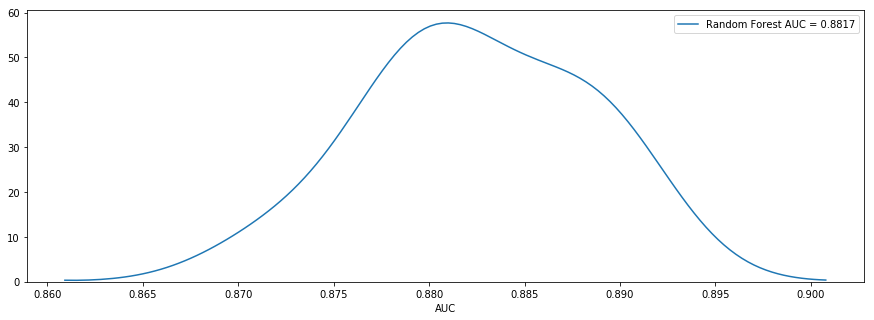

I am 95% confident that the AUC of the model in production will be:

Random Forest: between 0.874 and 0.889





In [68]:
models_list = [{'label': 'Random Forest','model': rf,}]

models_evaluation(models=models_list, 
                  df=df_stacking,
                  iterations=10,
                  ROC=False)

## Model Explainability

#### Decision Tree Plot

Random forest works on several decision tree. Plotting one of them (we don't want to visualize them all!) gives a general understanding about how the model predicts the value of a target variable by learning simple decision rules inferred from the data features.

By double-clicking on the chart, you can zoom/unzoon it.

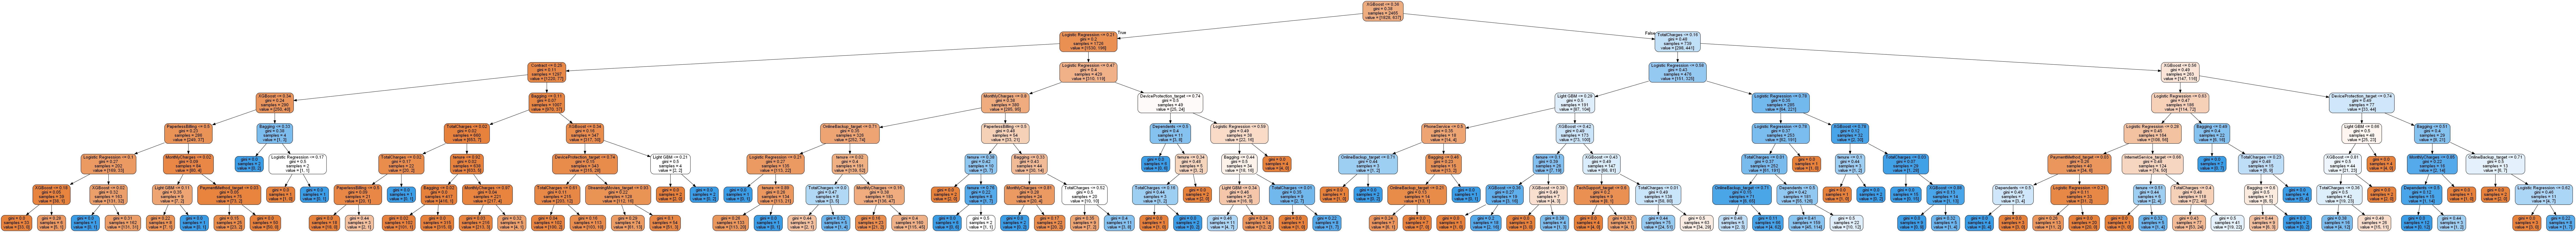

In [27]:
rf.fit(X_train_2_stacking, y_train_2)
export_graphviz(rf.estimators_[0],
                out_file='tree.dot',
                feature_names=list(X_train_2_stacking),
                filled=True,
                proportion = False, 
                precision = 2, 
                rounded=True)
(graph,) = pydot.graph_from_dot_file('tree.dot')
os.system('dot -Tpng tree.dot -o tree.png')
display(Image(filename='tree.png'))

#### Features Importance Plots

I can check if the extra features I created were actually important.

Text(0, 0.5, 'Features')

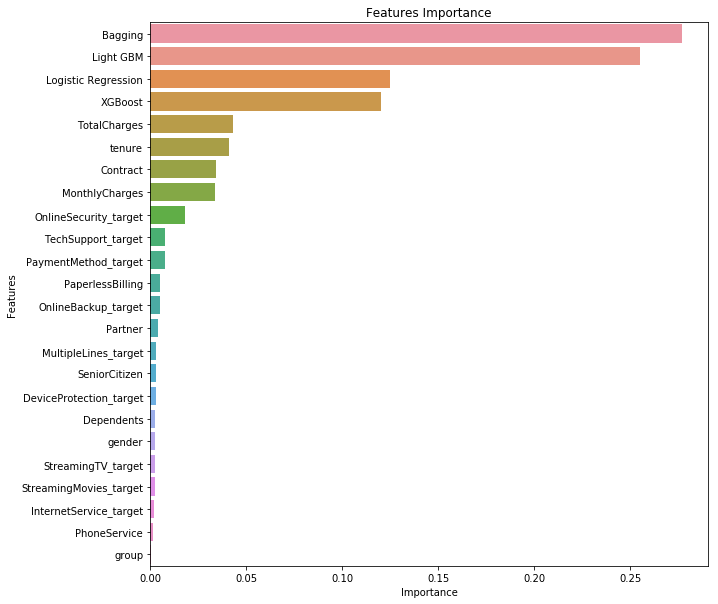

In [32]:
# Set the model to use
classifier=rf

# Set the width and height of the figure
plt.figure(figsize=(10,10))

# Add title
plt.title('Features Importance')

# Bar chart showing the importance of the imput features
features_importance = pd.concat([pd.DataFrame(X_train_2_stacking.columns),pd.DataFrame(classifier.feature_importances_)], axis=1)
features_importance.columns = ['Feature','Importance']
features_importance = features_importance.sort_values('Importance',ascending=False)
sns.barplot(x=features_importance.iloc[:,1], y=features_importance.iloc[:,0])

# Add label for vertical axis
plt.xlabel('Importance')
plt.ylabel('Features')

#### Partial Dependence Plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions. It can be interpreted similarly to the coefficients of logistic regression models. Though, partial dependence plots are built on more sophisticated models and they can capture more complex patterns compared to simpler model such as the coefficient of the logist regression.

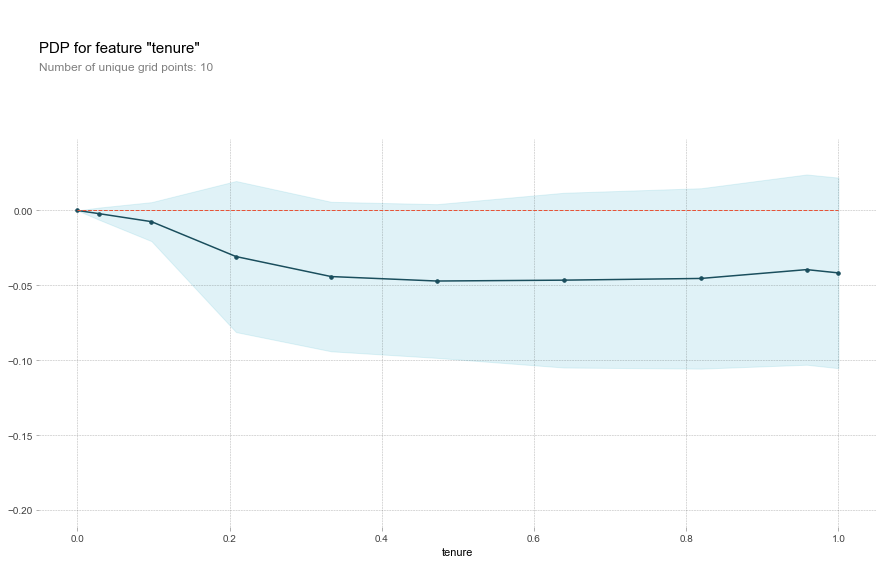

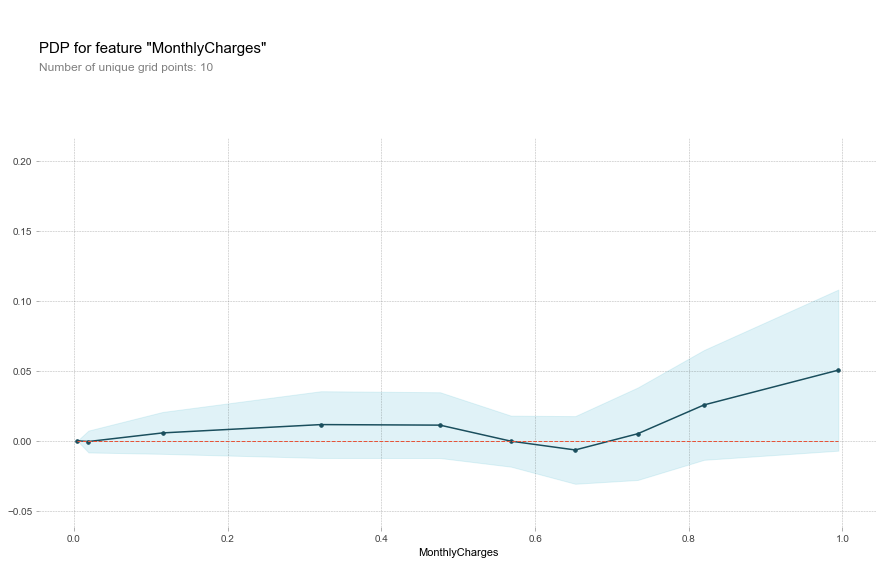

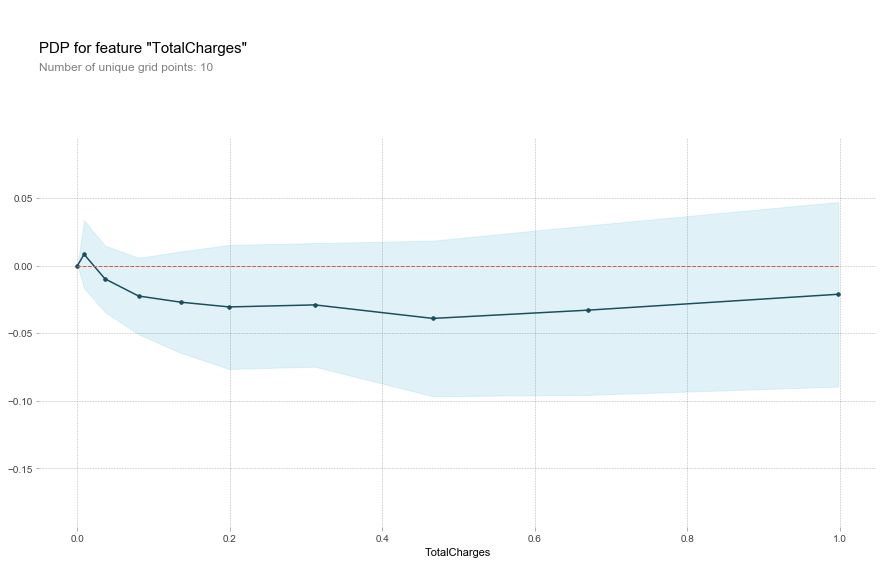

In [34]:
feature_to_plot=['tenure', 'MonthlyCharges', 'TotalCharges']

for i in feature_to_plot:
    pdp_i = pdp.pdp_isolate(model=classifier, 
                            dataset=X_train_2_stacking, 
                            model_features=list(X_train_2_stacking), 
                            feature=i)
    pdp.pdp_plot(pdp_i, i)
    plt.show()

Please notice the followings in order to interpret the above plots:

- The y axis is interpreted as a change in the prediction from what it would be predicted at the baseline or leftmost value.
- The blue shaded area indicates the level of confidence

#### 2D Partial Dependence Plots
If you are curious about interactions between features, 2D partial dependence plots are also useful. 

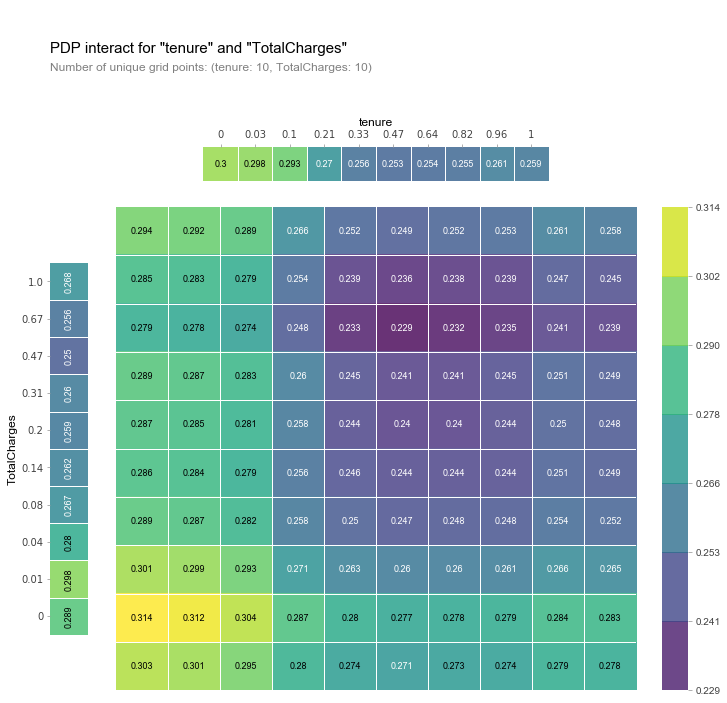

In [47]:
fnames = ['tenure', 'TotalCharges']
longitudes_partial_plot  =  pdp.pdp_interact(model=rf, dataset=X_train_2_stacking, model_features=X_train_2_stacking.columns, features=fnames)
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=longitudes_partial_plot,feature_names=fnames, plot_type='grid', plot_pdp=True)

plt.show()

I have shown few techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?

#### SHAP Values
It is an acronym from SHapley Additive exPlanations) decomposes a prediction by the impact of each feature. Let's visualize a user randomly sampled from the Top Customers:

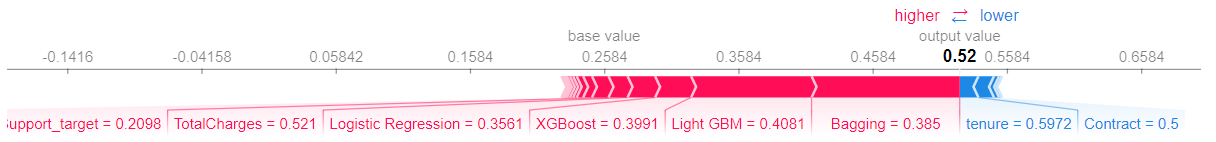

In [79]:
def shap_value(Dataset,value):
    customer_id = random.choice(list(predicted_prob[predicted_prob['Target']==value].index))
    data_for_prediction = Dataset[Dataset.index==customer_id]  # use 1 row of data here. Could use multiple rows if desired
    data_for_prediction.drop('Target',axis=1,inplace=True)
    data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
    classifier.predict_proba(data_for_prediction_array)
    explainer = shap.TreeExplainer(classifier) # Create object that can calculate shap values
    shap_values = explainer.shap_values(data_for_prediction) # Calculate Shap values
    shap.initjs()  
    return shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

test_set = pd.concat([X_test_stacking,y_test],axis=1)
shap_value(test_set,1)
Image(filename = PATH + 'SHAP_1.png', width=1000, height=200)

-  <span style="color:red">Feature values causing increased predictions are in red</span>, and their visual size shows the magnitude of the feature's effect. 
- <span style="color:blue">Feature values decreasing the prediction are in blue</span>.  

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

Here there is another one for Target=0:

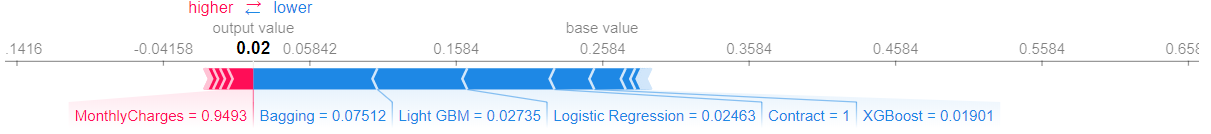

In [81]:
shap_value(test_set,0)
Image(filename = PATH + 'SHAP_0.png', width=1000, height=200)

Now, we'll expand on the SHAP values, seeing how aggregating many SHAP values can give more detailed alternatives to feature importance and partial dependence plots.

For example, feature importance doesn't say how much each features matter. If a feature has medium permutation importance, that could mean it has:
- a large effect for a few predictions, but no effect in general
- a medium effect for all predictions.

SHAP summary plots give us a bird-eye view of feature importance and what is driving it:

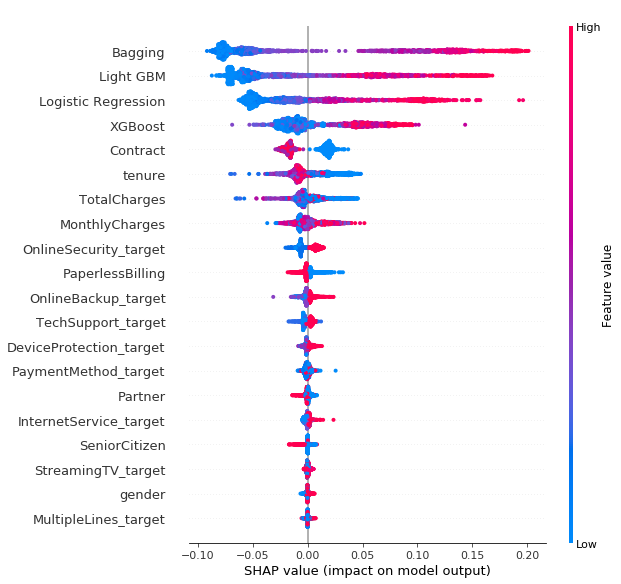

In [83]:
# Create object that can calculate the SHAP values
explainer = shap.TreeExplainer(classifier)

# Calculate shap_values for a subset of X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_stacking)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test_stacking)

This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play. Let's see the distribution of 'tenure' and its interaction with the 'TotalCharges', which are 2 of the most important features: 

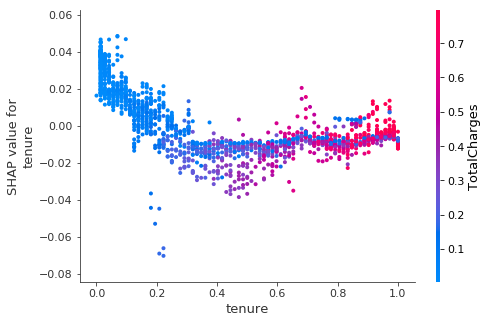

In [84]:
# Create object that can calculate the SHAP values
explainer = shap.TreeExplainer(classifier)

# calculate shap_values. This is what we will plot.
shap_values = explainer.shap_values(X_test_stacking)

# make plot
shap.dependence_plot('tenure', shap_values[1], X_test_stacking, interaction_index='TotalCharges')